In [134]:
from statsbombpy import sb
import mplsoccer as mpl
from kloppy import metrica
import numpy as np
import matplotlib.pyplot as plt

# Colors

In [135]:
from matplotlib.colors import ListedColormap
def bulid_cmap(x, y):
    r,g,b = x
    r_, g_, b_ = y
    N = 256
    A = np.ones((N, 4))
    A[:, 0] = np.linspace(r, 1, N)
    A[:, 1] = np.linspace(g, 1, N)
    A[:, 2] = np.linspace(b, 1, N)
    cmp = ListedColormap(A)
    
    B = np.ones((N, 4))
    B[:, 0] = np.linspace(r_, 1, N)
    B[:, 1] = np.linspace(g_, 1, N)
    B[:, 2] = np.linspace(b_, 1, N)
    cmp_ = ListedColormap(B)
    
    newcolors = np.vstack((cmp(np.linspace(0, 1, 128)),
                            cmp_(np.linspace(1, 0, 128))))
    return ListedColormap(newcolors)
blue, red = (44,123,182), (215,25,28)
blue = [x/256 for x in blue]
red = [x/256 for x in red]
diverging = bulid_cmap(blue, red)
diverging_r = bulid_cmap(red, blue)

figsize = (9, 6)

Let's find the 2018 World cup


In [136]:
comps = sb.competitions()
comps.loc[(comps['competition_international'] == True)  & (comps['competition_gender'] == "male")].sort_values(by='season_name', ascending=False)

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
21,223,282,South America,Copa America,male,False,True,2024,2024-07-15T18:00:33.653673,None,None,2024-07-15T18:00:33.653673
68,55,282,Europe,UEFA Euro,male,False,True,2024,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,2024-07-15T15:52:24.778809,2024-07-15T15:48:50.315500
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
29,43,106,International,FIFA World Cup,male,False,True,2022,2024-05-15T10:23:32.854925,2024-06-11T11:30:50.462448,2024-06-11T11:30:50.462448,2024-05-15T10:23:32.854925
69,55,43,Europe,UEFA Euro,male,False,True,2020,2024-04-16T12:44:40.558402,2024-04-16T12:47:18.505110,2024-04-16T12:47:18.505110,2024-04-16T12:44:40.558402
30,43,3,International,FIFA World Cup,male,False,True,2018,2024-06-12T07:38:19.345758,2021-06-13T16:17:31.694,None,2024-06-12T07:38:19.345758
31,43,55,International,FIFA World Cup,male,False,True,1990,2023-06-28T10:58:20.137929,2021-06-12T16:17:31.694,None,2023-06-28T10:58:20.137929
32,43,54,International,FIFA World Cup,male,False,True,1986,2023-12-26T22:34:04.263530,2021-06-13T16:17:31.694,None,2023-12-26T22:34:04.263530
33,43,51,International,FIFA World Cup,male,False,True,1974,2024-02-13T02:52:29.582599,2021-06-13T16:17:31.694,None,2024-02-13T02:52:29.582599
34,43,272,International,FIFA World Cup,male,False,True,1970,2024-02-13T14:23:06.735299,None,None,2024-02-13T14:23:06.735299


In [164]:
comps[comps['country_name'] == 'Germany']

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381


Let's have a look at France's matches.

In [137]:
matches = sb.matches(competition_id=43, season_id=3).sort_values('match_date', ascending=False)
france_matches = matches.loc[(matches['home_team'] == 'France') | (matches['away_team'] == 'France')]
france_matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
39,8658,2018-07-15,17:00:00.000,International - FIFA World Cup,2018,France,Croatia,4,2,available,...,2021-06-13T16:17:31.694,7,Final,Stadion Luzhniki,Néstor Fabián Pitana,Didier Deschamps,Zlatko Dalić,1.0.2,None,None
57,8655,2018-07-10,20:00:00.000,International - FIFA World Cup,2018,France,Belgium,1,0,available,...,2021-06-13T16:17:31.694,6,Semi-finals,Saint-Petersburg Stadium,Andrés Cunha,Didier Deschamps,Roberto Martínez Montoliú,1.0.2,None,None
38,8649,2018-07-06,16:00:00.000,International - FIFA World Cup,2018,Uruguay,France,0,2,available,...,2021-06-13T16:17:31.694,5,Quarter-finals,Stadion Nizhny Novgorod (Nizhniy Novgorod),Néstor Fabián Pitana,Óscar Washington Tabárez Silva,Didier Deschamps,1.0.2,None,None
21,7580,2018-06-30,16:00:00.000,International - FIFA World Cup,2018,France,Argentina,4,3,available,...,2021-06-13T16:17:31.694,4,Round of 16,Ak Bars Arena,Alireza Faghani,Didier Deschamps,Jorge Luis Sampaoli Moya,1.0.2,None,None
61,7563,2018-06-26,16:00:00.000,International - FIFA World Cup,2018,Denmark,France,0,0,available,...,2021-06-13T16:17:31.694,3,Group Stage,Stadion Luzhniki,Sandro Ricci,Åge Fridtjof Hareide,Didier Deschamps,1.0.2,None,None
14,7546,2018-06-21,17:00:00.000,International - FIFA World Cup,2018,France,Peru,1,0,available,...,2021-06-13T16:17:31.694,2,Group Stage,\tEkaterinburg Arena,Mohamed Abdulla Hassan Mohd,Didier Deschamps,Ricardo Alberto Gareca Nardi,1.0.2,None,None
31,7530,2018-06-16,12:00:00.000,International - FIFA World Cup,2018,France,Australia,2,1,available,...,2021-06-13T16:17:31.694,1,Group Stage,Ak Bars Arena,Andrés Cunha,Didier Deschamps,Lambertus van Marwijk,1.0.2,None,None


4-3 in the Round of 16, that was a good game.

In [138]:
match_id = france_matches.loc[france_matches['competition_stage'] == 'Round of 16'].match_id.item()

events = sb.events(match_id = match_id)

In [139]:
passes = events[(events['type'] == "Pass") & 
                (events['player_id'] == 5484)]

shots = events[(events['type'] == "Shot") &
               (events['player_id'] == 5476)]

In [140]:
shots['shot_statsbomb_xg']

3480    0.02415
Name: shot_statsbomb_xg, dtype: float64

In [141]:
pass_coordinates = passes[['location', 'pass_end_location']]
shot_coordinates = shots[['location', 'shot_end_location']]

In [142]:
x1_pass, y1_pass = np.array(pass_coordinates['location'].tolist()).T
x2_pass, y2_pass = np.array(pass_coordinates['pass_end_location'].tolist()).T

In [143]:
x1_shot, y1_shot = np.array(shot_coordinates['location'].tolist()).T
x2_shot, y2_shot, outcome = np.array(shot_coordinates['shot_end_location'].tolist()).T

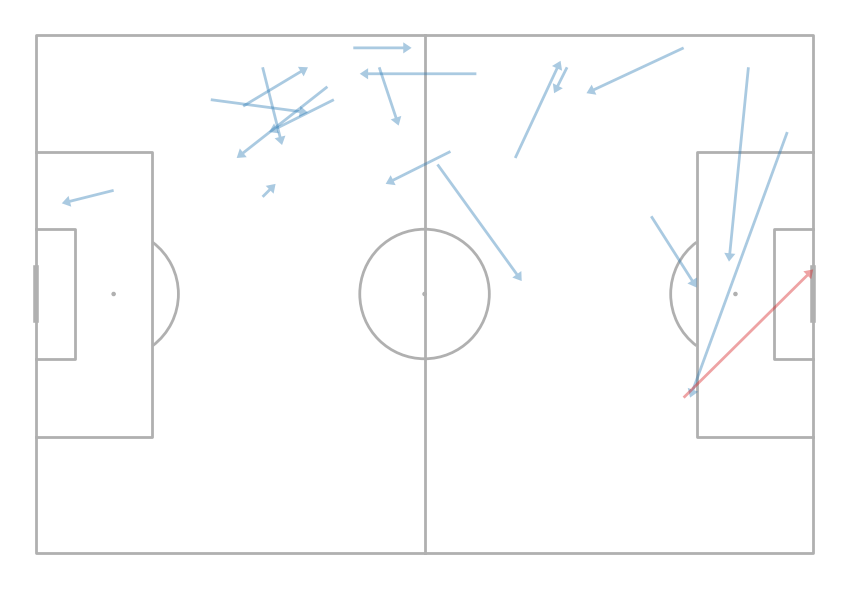

In [144]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)

p = pitch.arrows(x1_pass, y1_pass, x2_pass, y2_pass, alpha=0.4, color=blue,
                 headaxislength=3, headlength=3, headwidth=4, width=2, ax=ax)
p = pitch.arrows(x1_shot, y1_shot, x2_shot, y2_shot, alpha=0.4, color=red,
                 headaxislength=3, headlength=3, headwidth=4, width=2, ax=ax)

# Implementing the expected threat (xT) algorithm for a specific match

In [145]:
import pandas as pd

In [171]:
comps = sb.competitions()
comps[comps['country_name'] == 'Spain']

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
22,87,84,Spain,Copa del Rey,male,False,False,1983/1984,2024-02-13T01:54:12.946985,2021-06-13T16:17:31.694,None,2024-02-13T01:54:12.946985
23,87,268,Spain,Copa del Rey,male,False,False,1982/1983,2024-02-13T14:19:57.954551,None,None,2024-02-13T14:19:57.954551
24,87,279,Spain,Copa del Rey,male,False,False,1977/1978,2024-02-13T14:26:19.978418,None,None,2024-02-13T14:26:19.978418
38,11,90,Spain,La Liga,male,False,False,2020/2021,2024-07-15T15:15:28.367546,2024-07-15T15:17:45.455234,2024-07-15T15:17:45.455234,2024-07-15T15:15:28.367546
39,11,42,Spain,La Liga,male,False,False,2019/2020,2024-07-12T16:27:54.561817,2021-06-13T16:17:31.694,None,2024-07-12T16:27:54.561817
40,11,4,Spain,La Liga,male,False,False,2018/2019,2024-06-12T07:42:36.910303,2021-07-09T14:53:22.103024,None,2024-06-12T07:42:36.910303
41,11,1,Spain,La Liga,male,False,False,2017/2018,2024-06-12T07:32:43.196678,2021-06-13T16:17:31.694,None,2024-06-12T07:32:43.196678
42,11,2,Spain,La Liga,male,False,False,2016/2017,2024-03-12T08:49:46.449084,2021-06-13T16:17:31.694,None,2024-03-12T08:49:46.449084
43,11,27,Spain,La Liga,male,False,False,2015/2016,2024-05-16T14:06:52.149840,2021-06-13T16:17:31.694,None,2024-05-16T14:06:52.149840
44,11,26,Spain,La Liga,male,False,False,2014/2015,2023-09-20T17:22:28.925900,2021-06-13T16:17:31.694,None,2023-09-20T17:22:28.925900


In [182]:
matches = sb.matches(competition_id=11, season_id=90).sort_values('match_date', ascending=False)
matches = matches[(matches['home_team'] == 'Real Madrid') | (matches['away_team'] == 'Real Madrid')]    
matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
5,3773497,2021-04-10,21:00:00.000,Spain - La Liga,2020/2021,Real Madrid,Barcelona,2,1,available,...,2023-04-28T01:35:16.051381,30,Regular Season,Estadio Alfredo Di Stéfano,Jesús Gil Manzano,Zinédine Zidane,Ronald Koeman,1.1.0,2,2
9,3773585,2020-10-24,16:00:00.000,Spain - La Liga,2020/2021,Barcelona,Real Madrid,1,3,available,...,2023-07-25T04:29:21.140321,7,Regular Season,Spotify Camp Nou,Juan Martínez Munuera,Ronald Koeman,Zinédine Zidane,1.1.0,2,2


In [183]:
all_match_ids = matches.match_id.to_list()
all_match_ids

[3773497, 3773585]

In [184]:
all_events = pd.DataFrame()

for match_id in all_match_ids:
    match_events = sb.events(match_id=match_id)
    all_events = pd.concat([all_events, match_events], ignore_index=True)

all_events

,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,...,team,team_id,timestamp,type,under_pressure,foul_committed_penalty,foul_won_penalty,injury_stoppage_in_chain,pass_cut_back,shot_one_on_one
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Real Madrid,220,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Barcelona,217,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Barcelona,217,00:00:00.000,Half Start,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Real Madrid,220,00:00:00.000,Half Start,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Barcelona,217,00:00:00.000,Half Start,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Barcelona,217,00:50:02.961,Half End,NaN,NaN,NaN,NaN,NaN,NaN
8200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Real Madrid,220,00:50:02.961,Half End,NaN,NaN,NaN,NaN,NaN,NaN
8201,Yellow Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Barcelona,217,00:16:16.207,Bad Behaviour,NaN,NaN,NaN,NaN,NaN,NaN
8202,Yellow Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Barcelona,217,00:46:54.439,Bad Behaviour,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
GRID_X, GRID_Y = 16, 12
pitch_x, pitch_y = 120, 80  # Standard pitch dimensions in meters
x_bins = np.linspace(0, pitch_x, GRID_X + 1)
y_bins = np.linspace(0, pitch_y, GRID_Y + 1)


In [186]:
def get_grid_cell(x, y):
    x_idx = np.digitize(x, x_bins) - 1
    y_idx = np.digitize(y, y_bins) - 1
    return x_idx, y_idx

In [187]:
transition_matrix = np.zeros((GRID_X, GRID_Y, GRID_X, GRID_Y))

In [188]:
# Extract relevant passes and carries
passes = all_events[all_events['type'] == 'Pass']
carries = all_events[all_events['type'] == 'Carry']
shots = all_events[all_events['type'] == 'Shot']

In [189]:
T = np.zeros((GRID_X, GRID_Y, GRID_X, GRID_Y))
S = np.zeros((GRID_X, GRID_Y))  # shot counts
M = np.zeros((GRID_X, GRID_Y))  # move counts

In [153]:
# Process passes and carries
for _, row in pd.concat([passes, carries]).iterrows():
    try:
        start_x, start_y = row['location']
        end = row.get('pass_end_location') if isinstance(row.get('pass_end_location'), list) else row.get('carry_end_location')
        if not isinstance(end, list):
            continue
        end_x, end_y = end
        sx, sy = get_grid_cell(start_x, start_y)
        ex, ey = get_grid_cell(end_x, end_y)
        if 0 <= sx < GRID_X and 0 <= sy < GRID_Y and 0 <= ex < GRID_X and 0 <= ey < GRID_Y:
            T[sx, sy, ex, ey] += 1
            M[sx, sy] += 1
    except:
        continue

In [154]:
# Process shots
for _, row in shots.iterrows():
    try:
        x, y = row['location']
        sx, sy = get_grid_cell(x, y)
        S[sx, sy] += row['shot_statsbomb_xg']
    except:
        continue

In [155]:
# Normalize transition probabilities
P_move = np.divide(M, M + S, out=np.zeros_like(M), where=(M + S) != 0)
P_shot = np.divide(S, M + S, out=np.zeros_like(S), where=(M + S) != 0)
P_trans = np.divide(T, T.sum(axis=(2,3), keepdims=True), out=np.zeros_like(T), where=T.sum(axis=(2,3), keepdims=True)!=0)


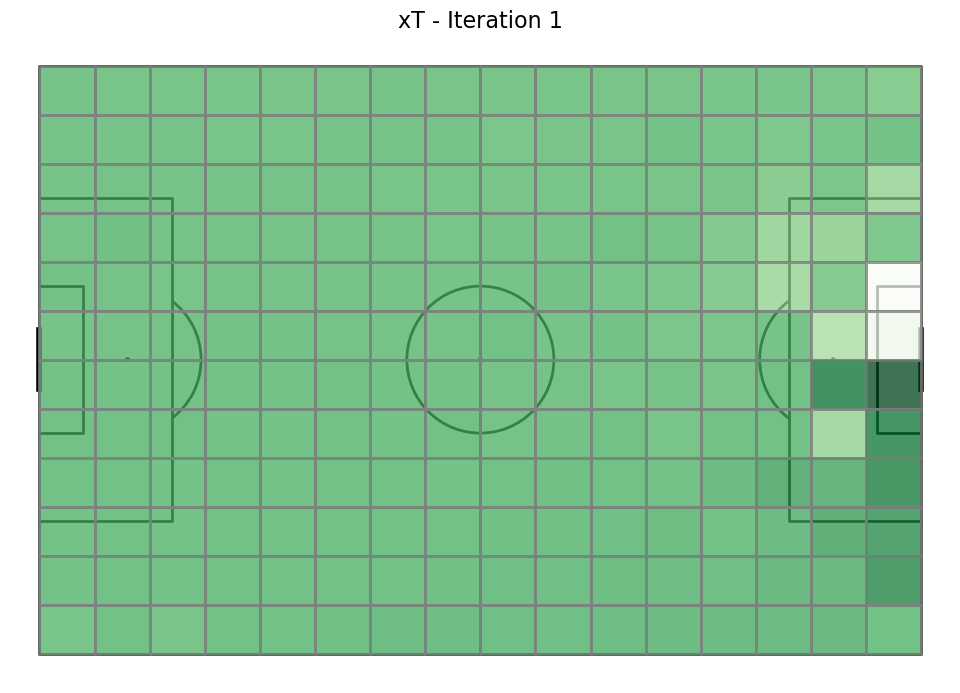

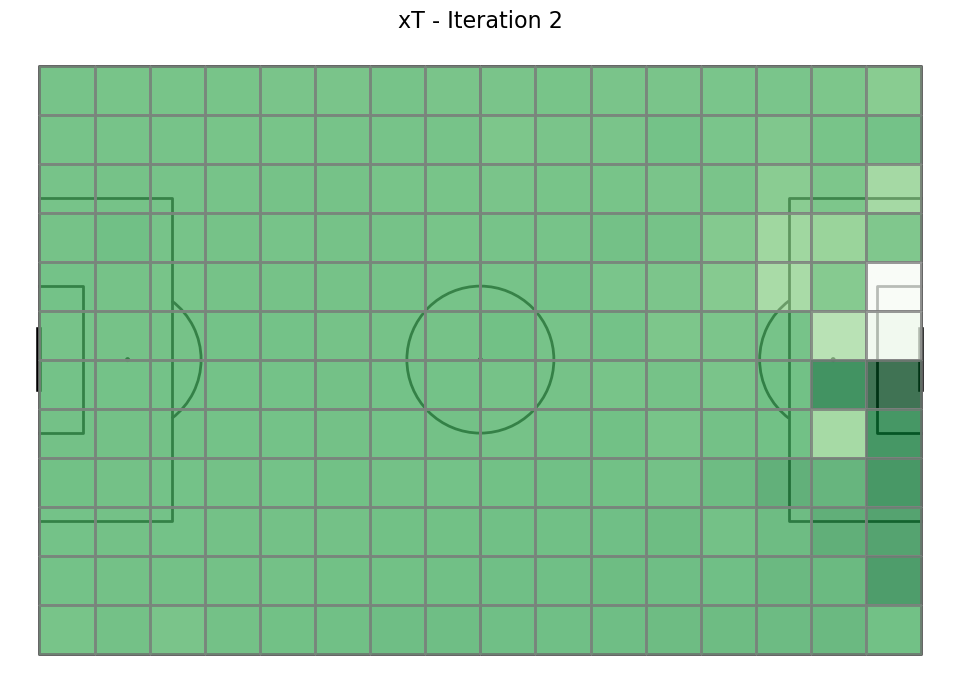

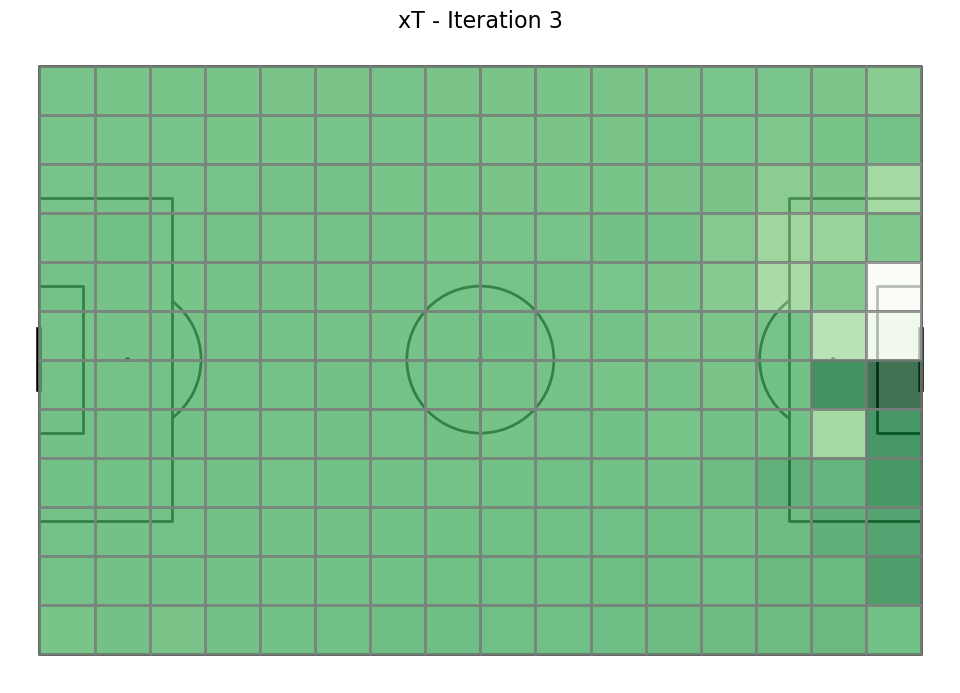

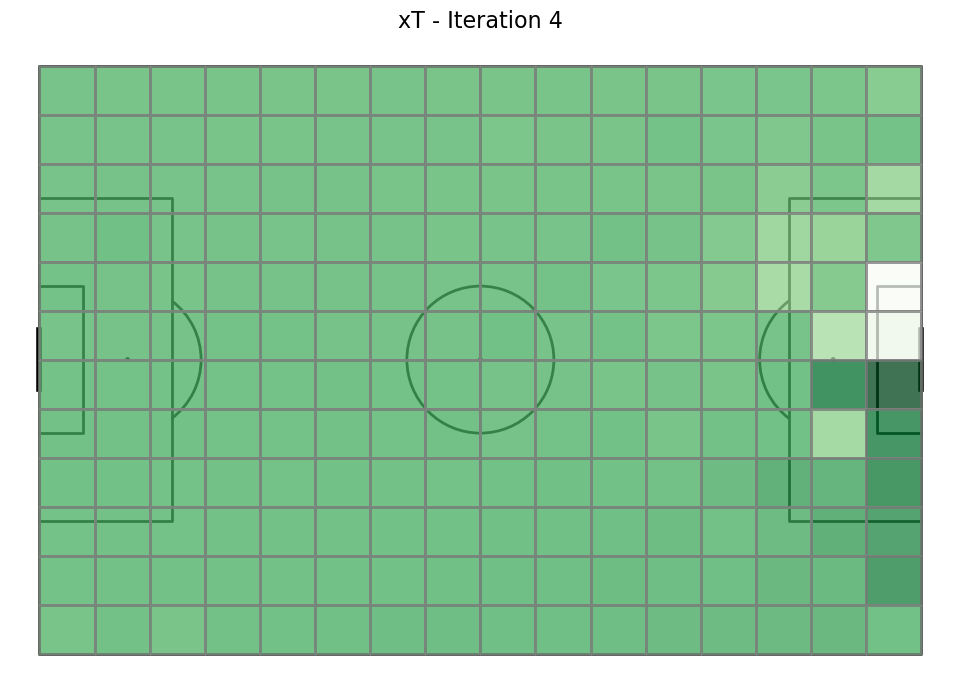

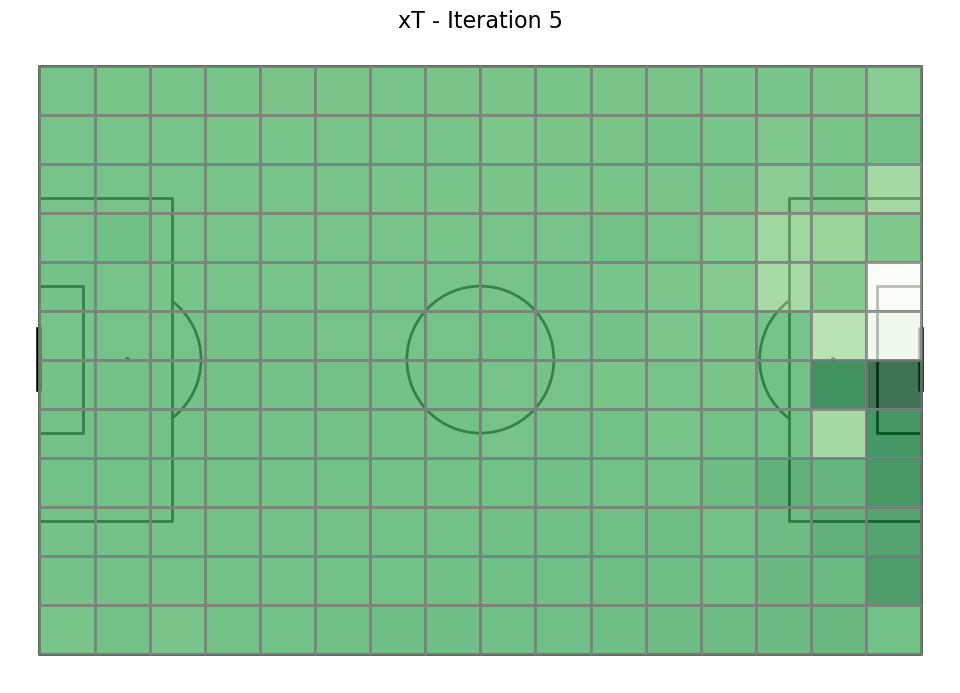

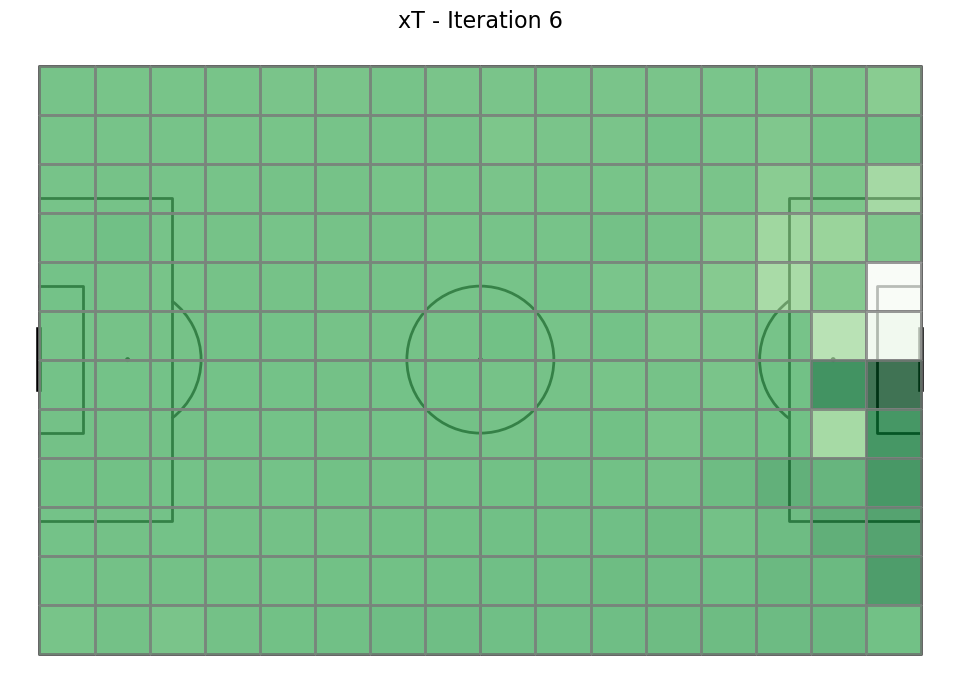

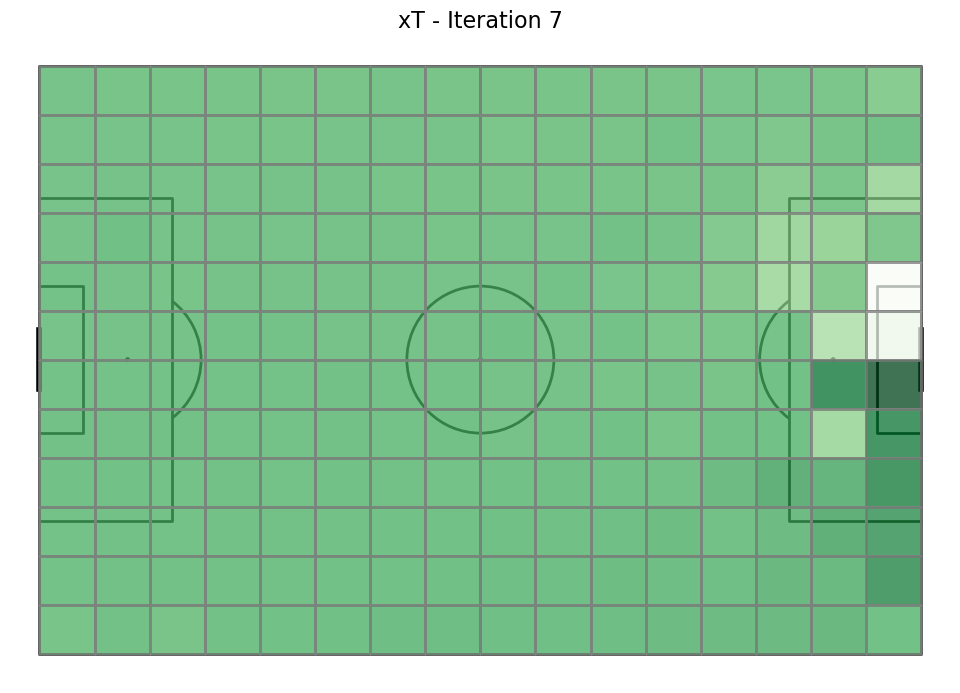

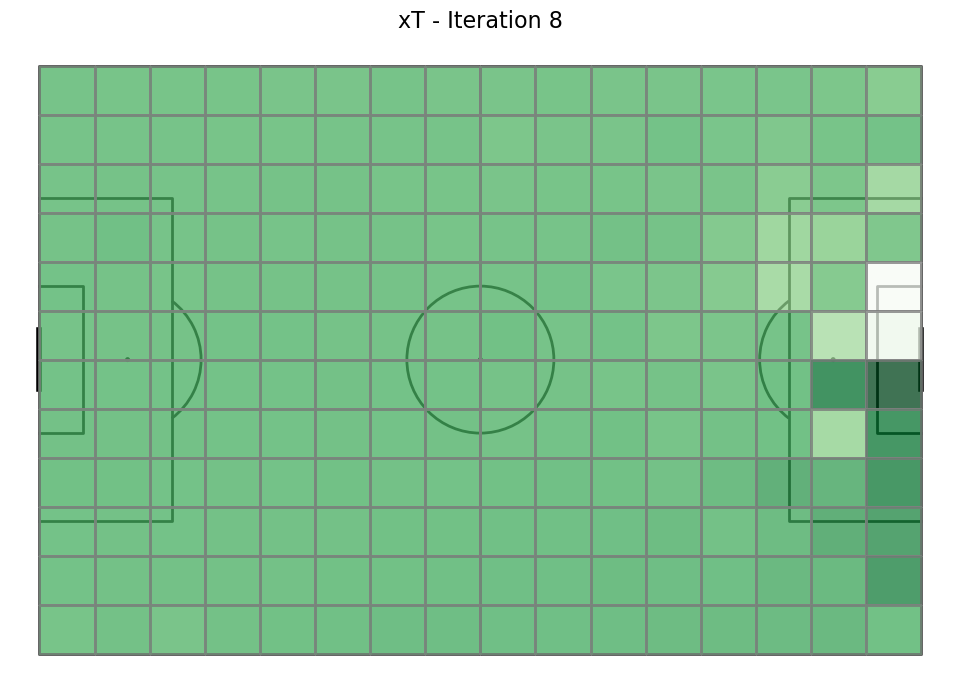

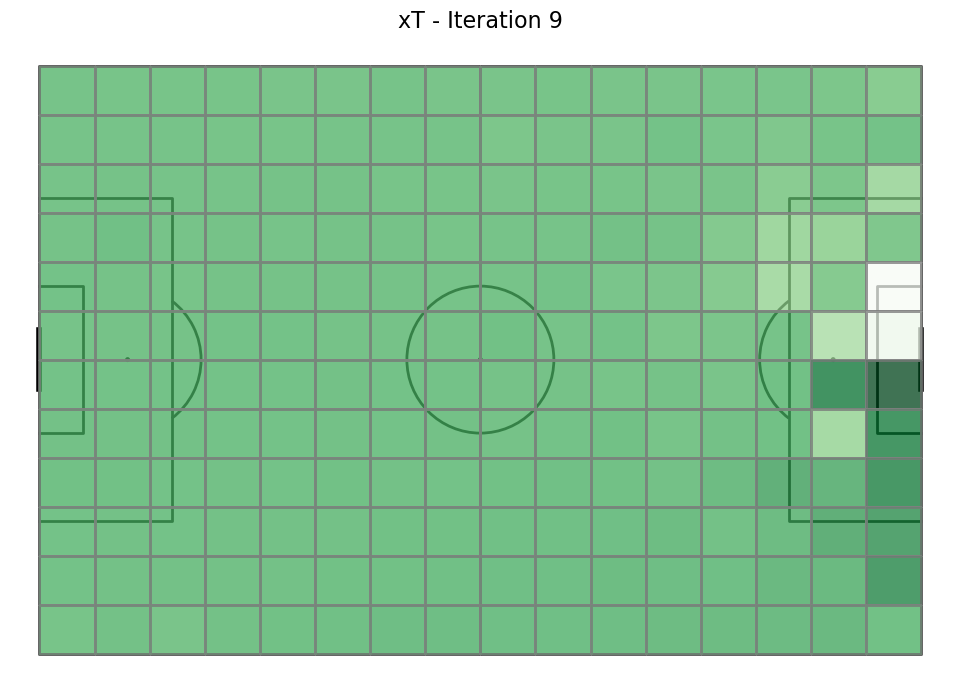

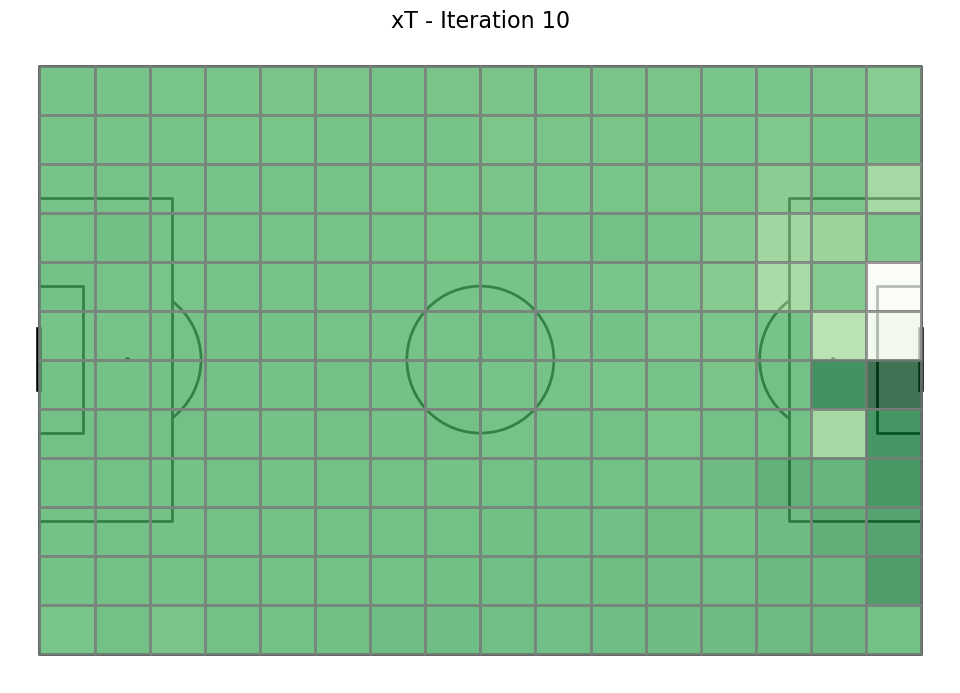

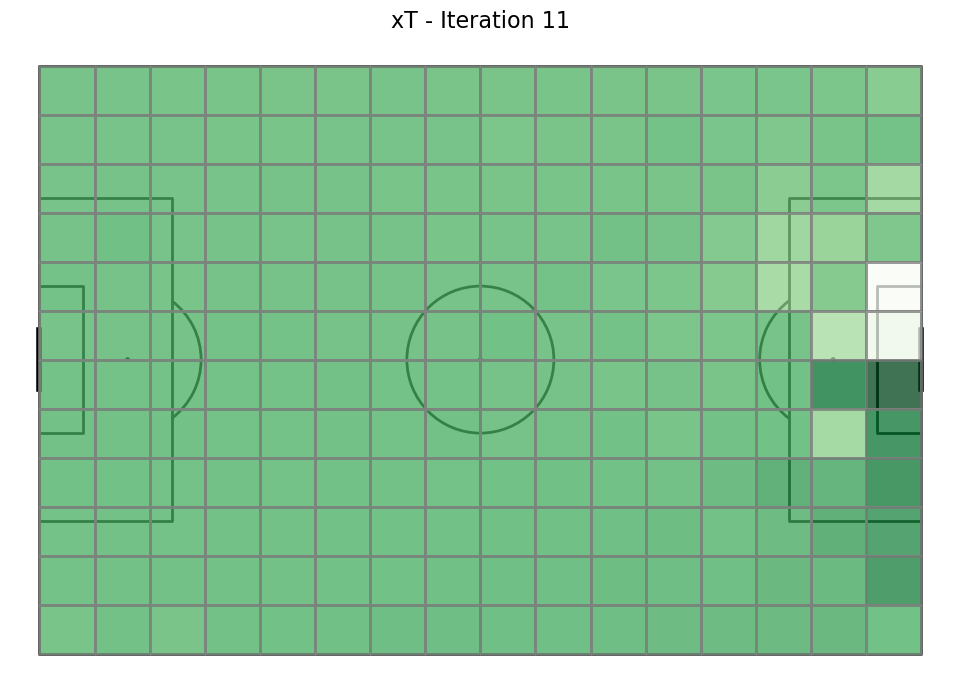

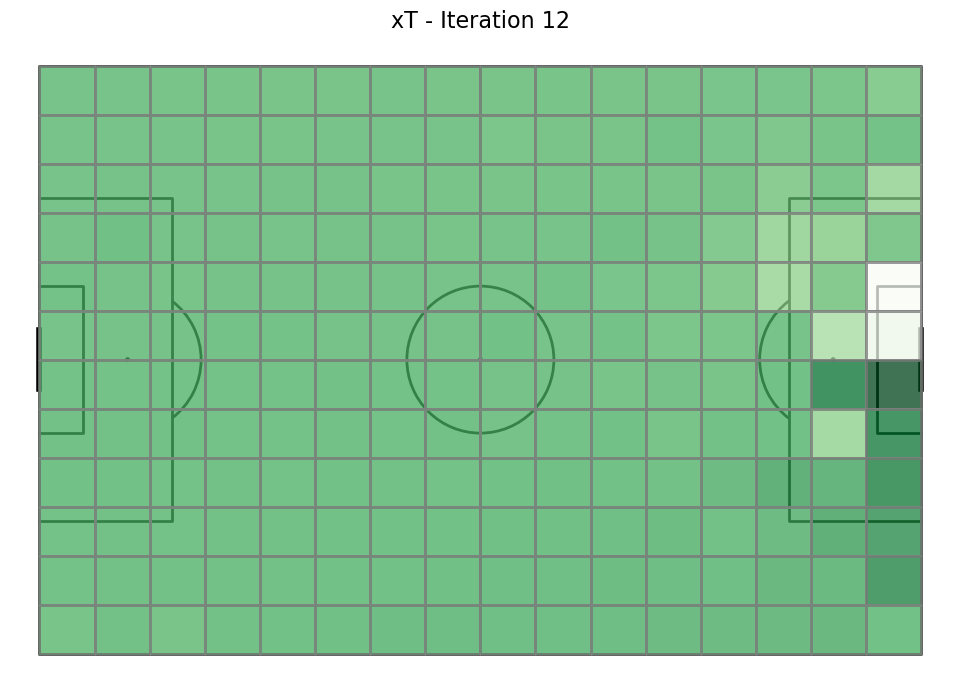

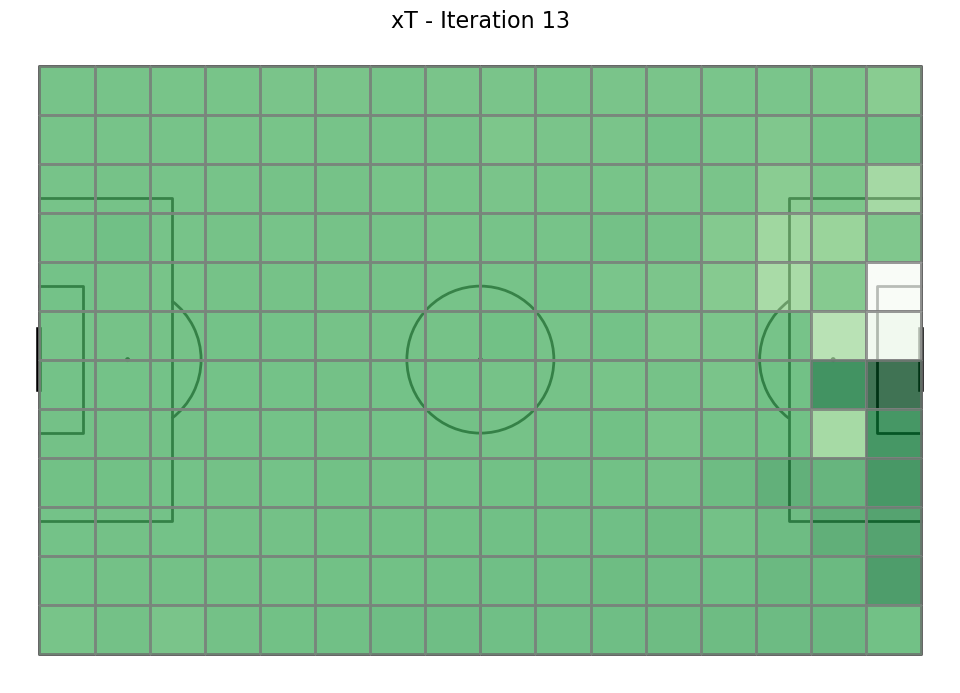

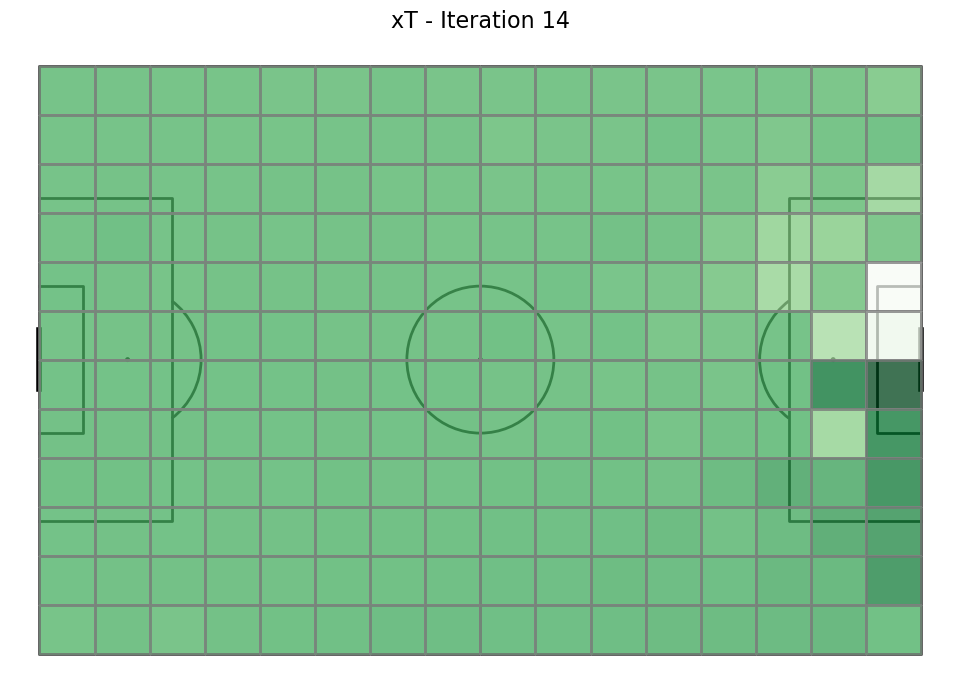

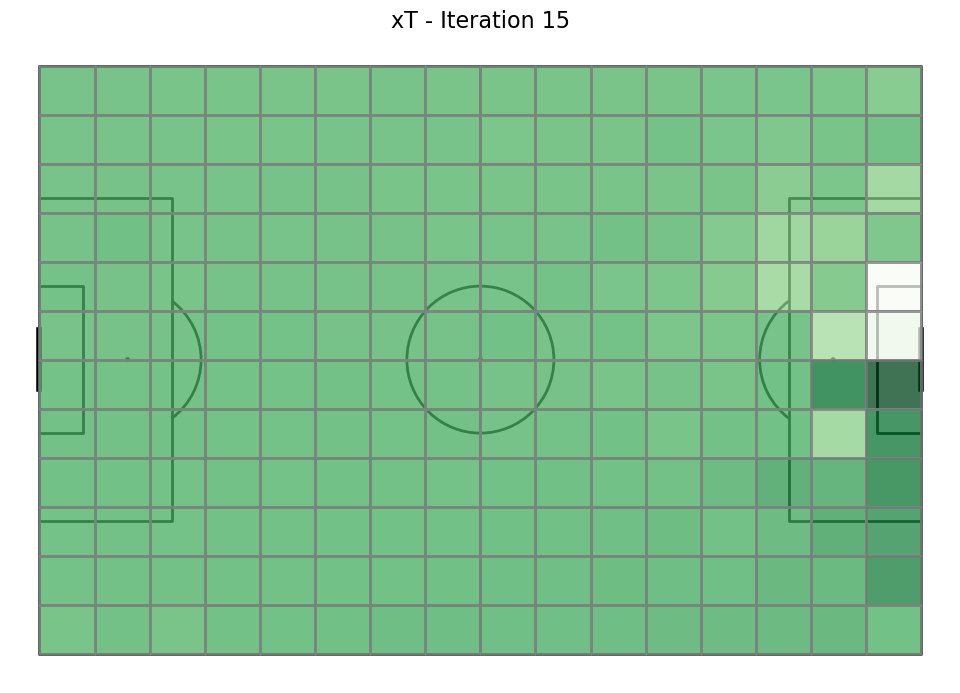

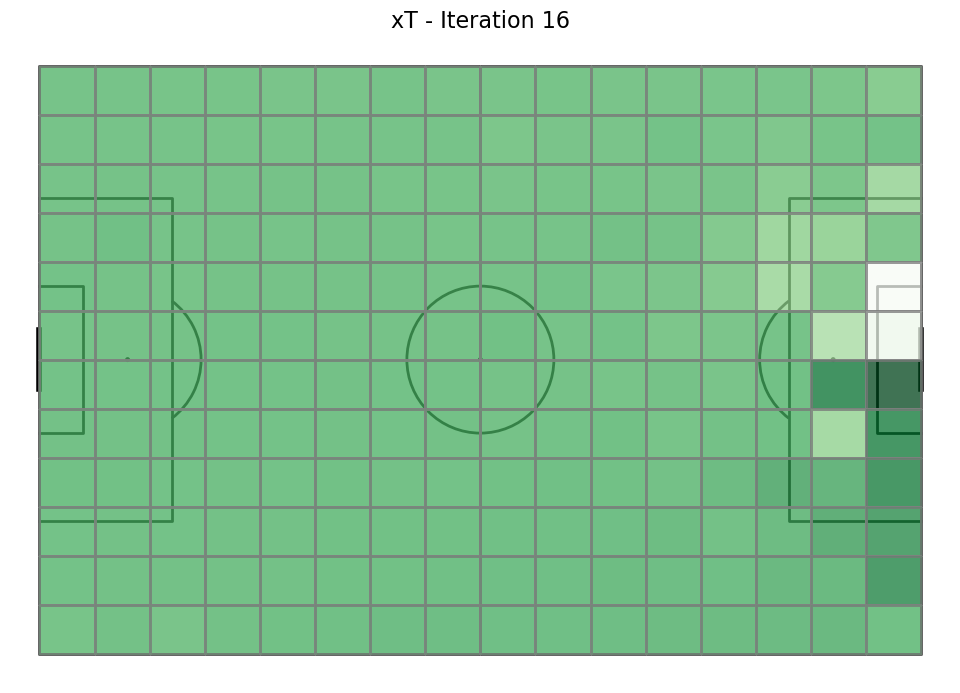

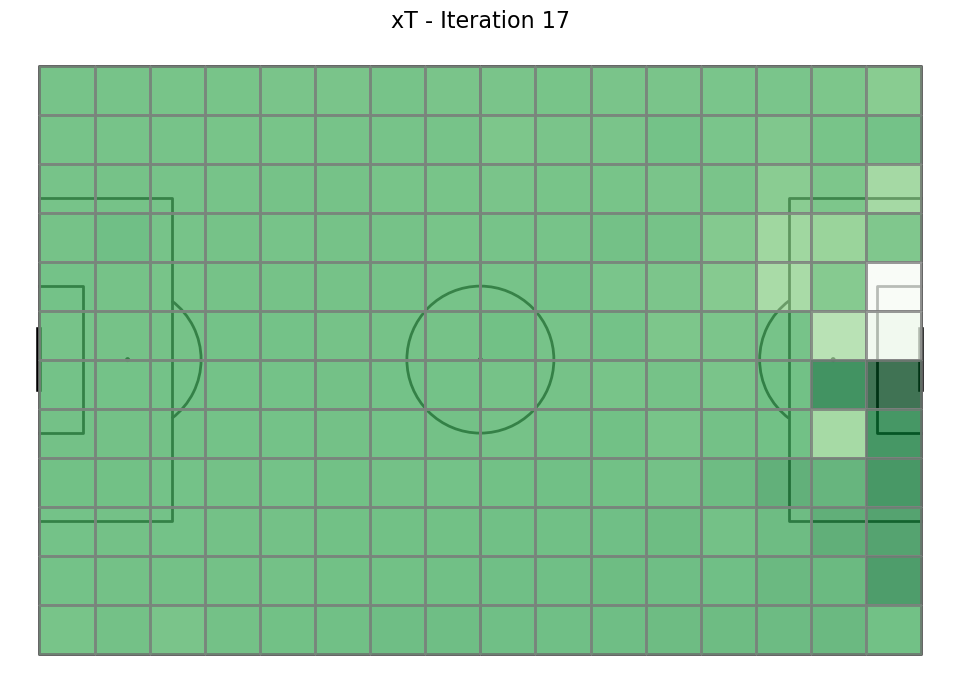

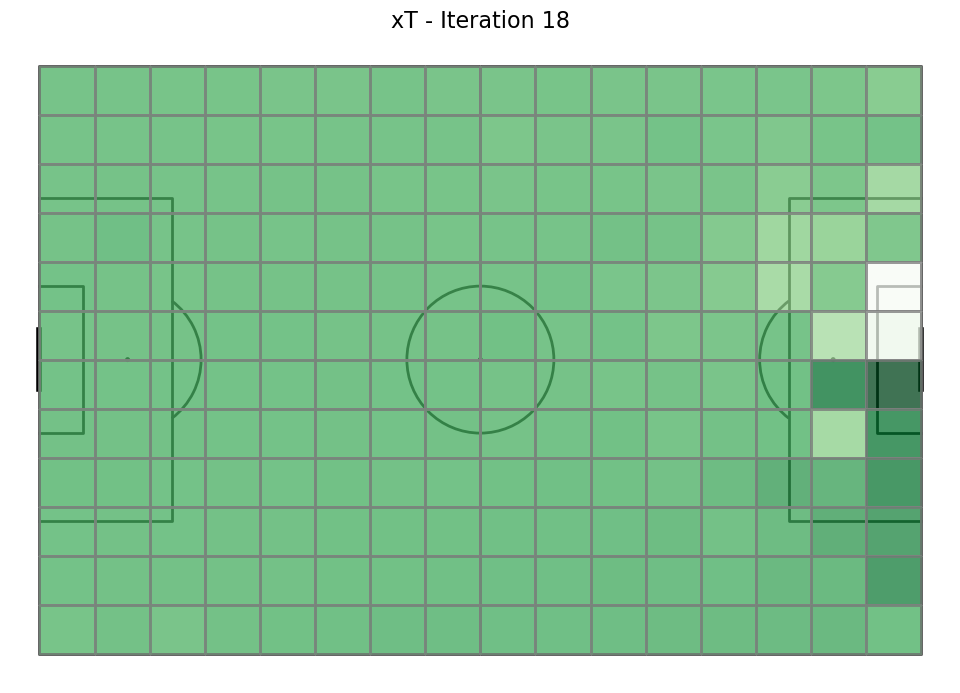

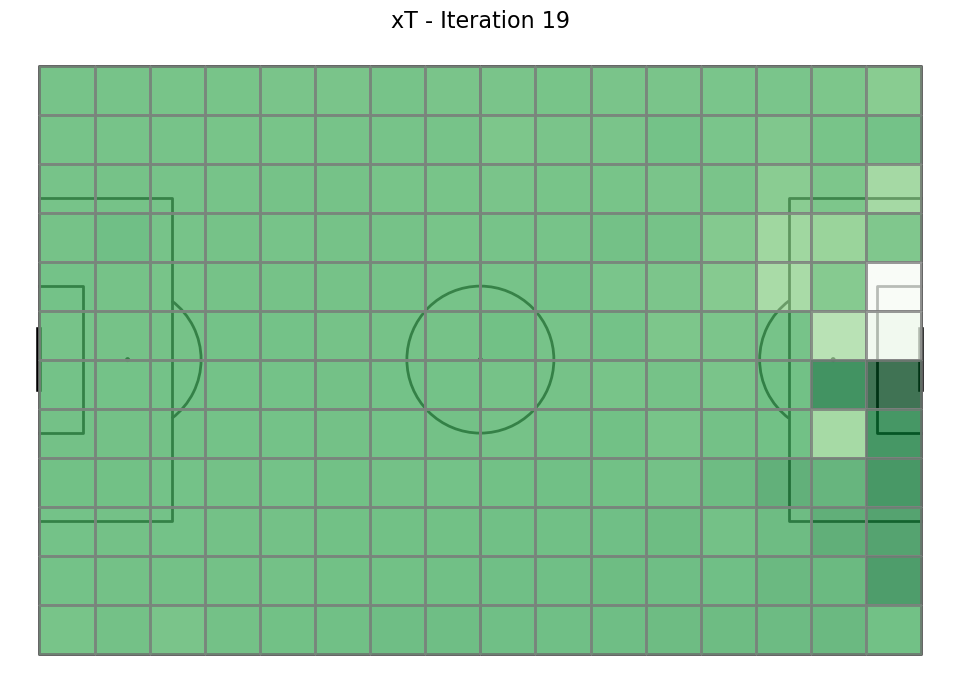

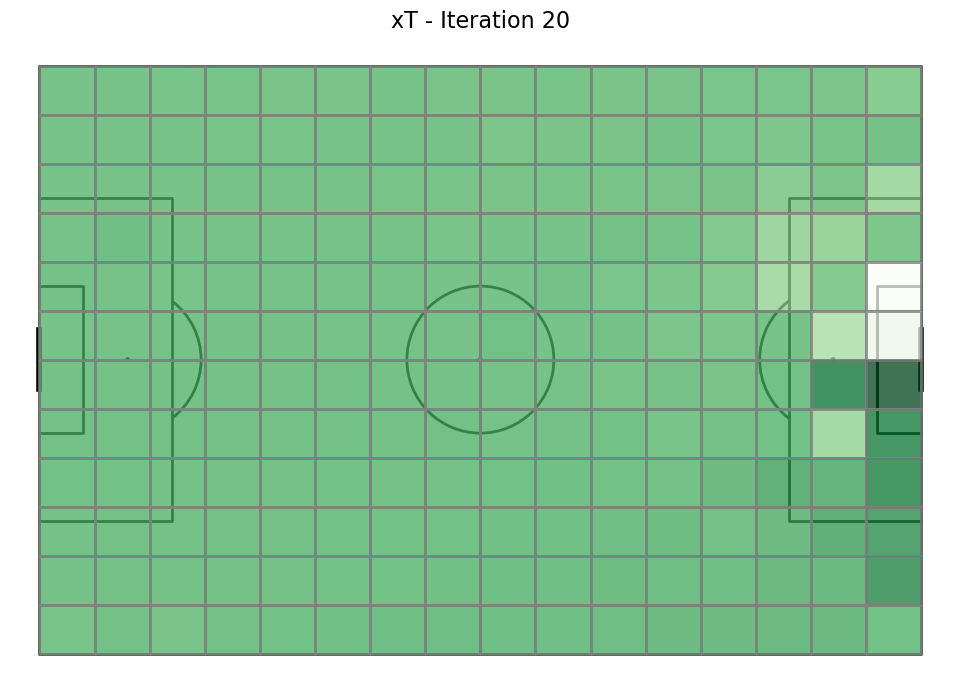

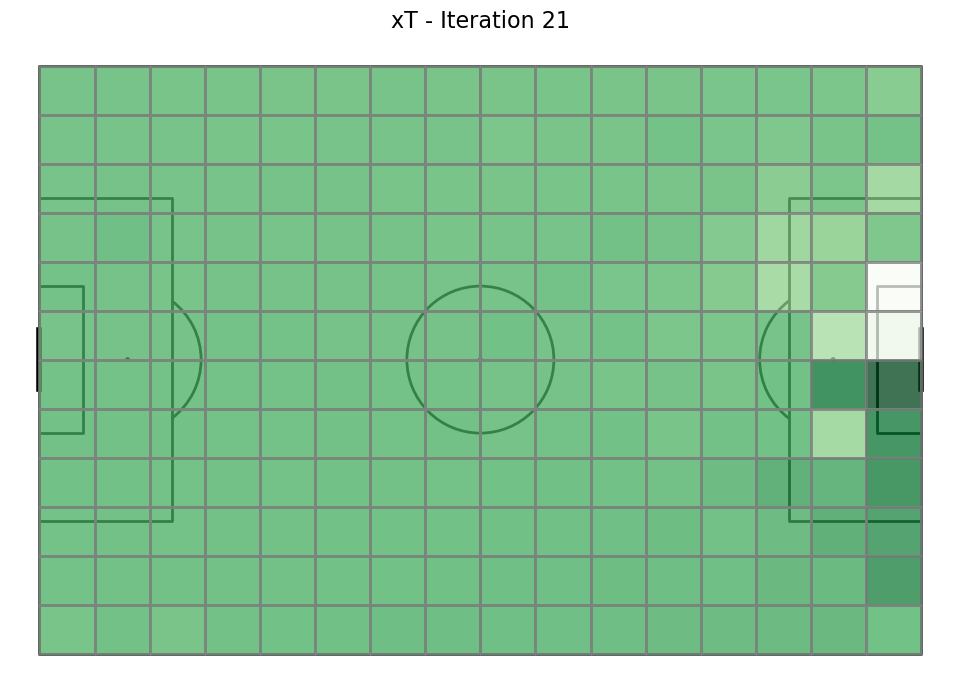

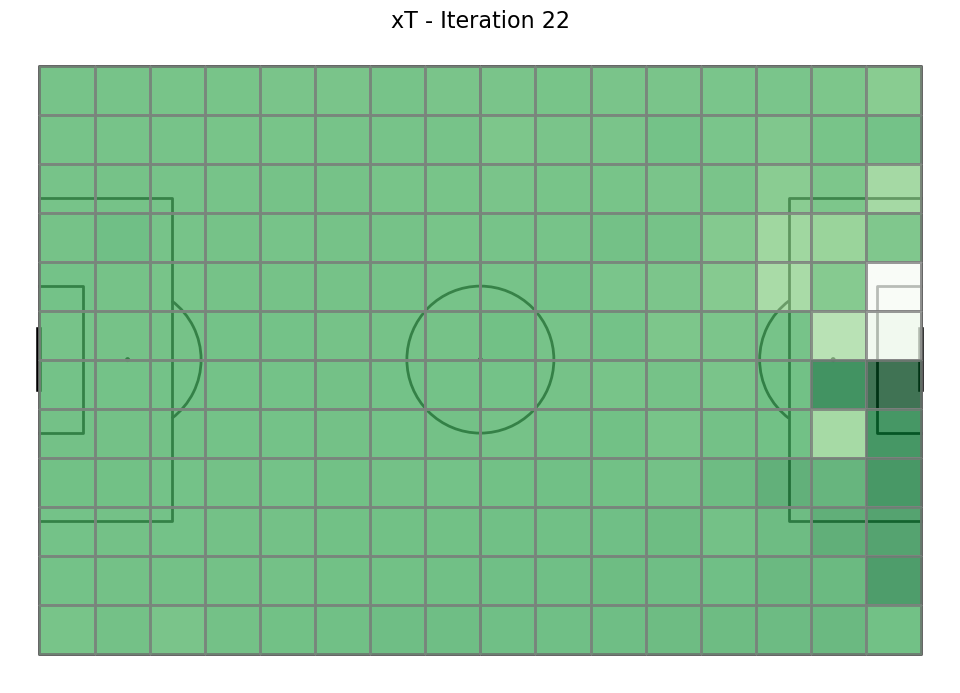

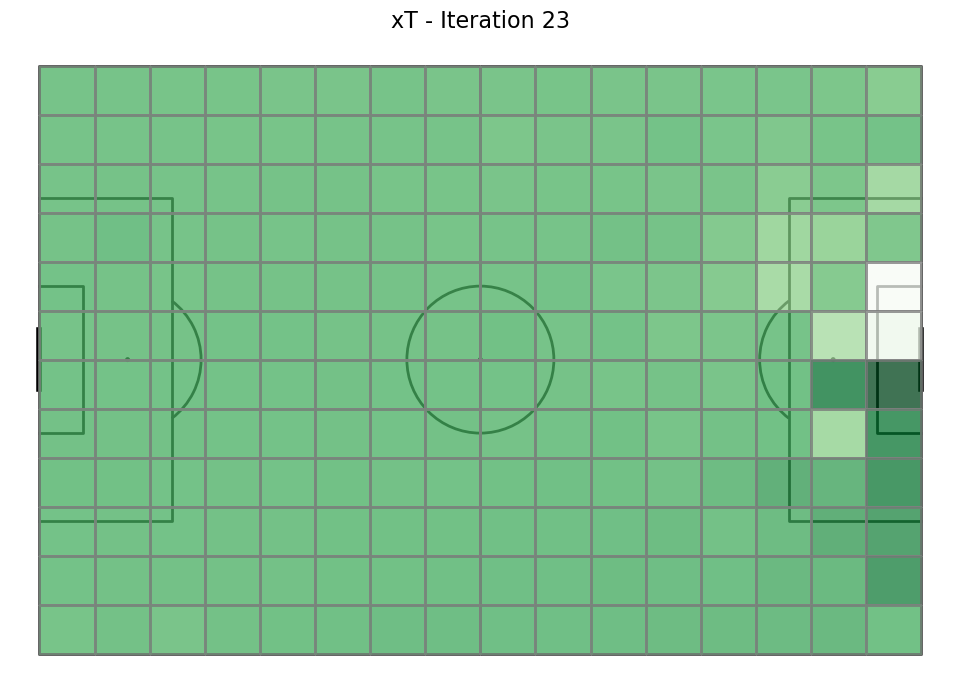

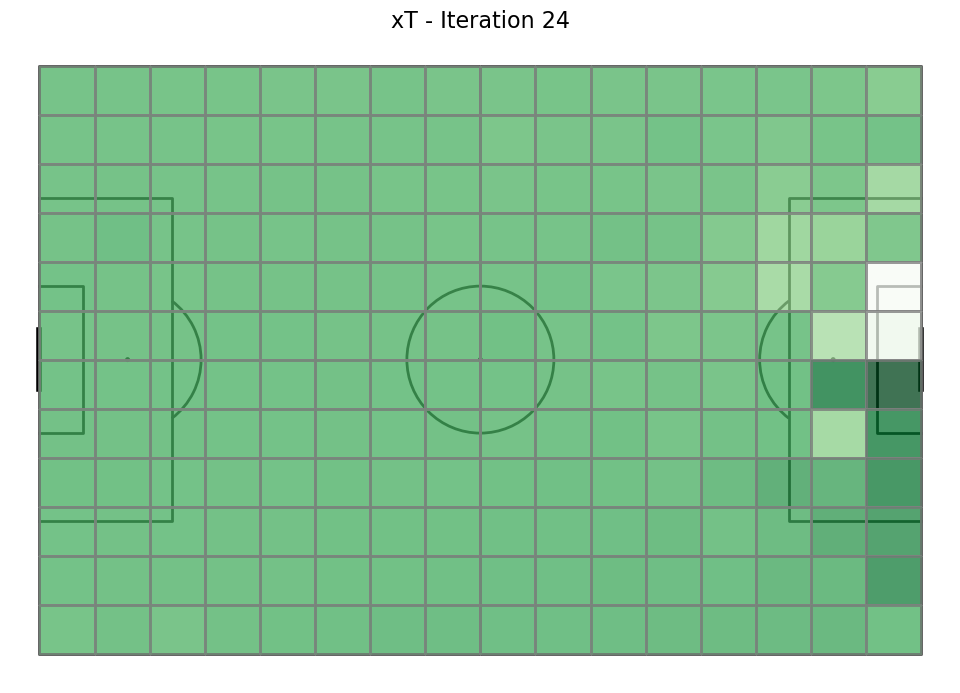

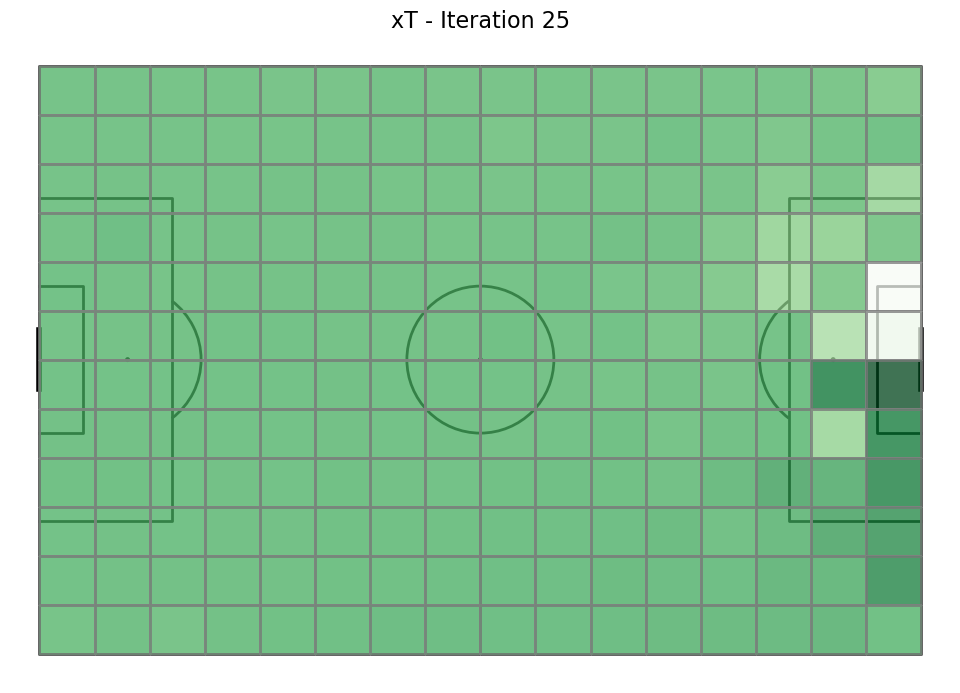

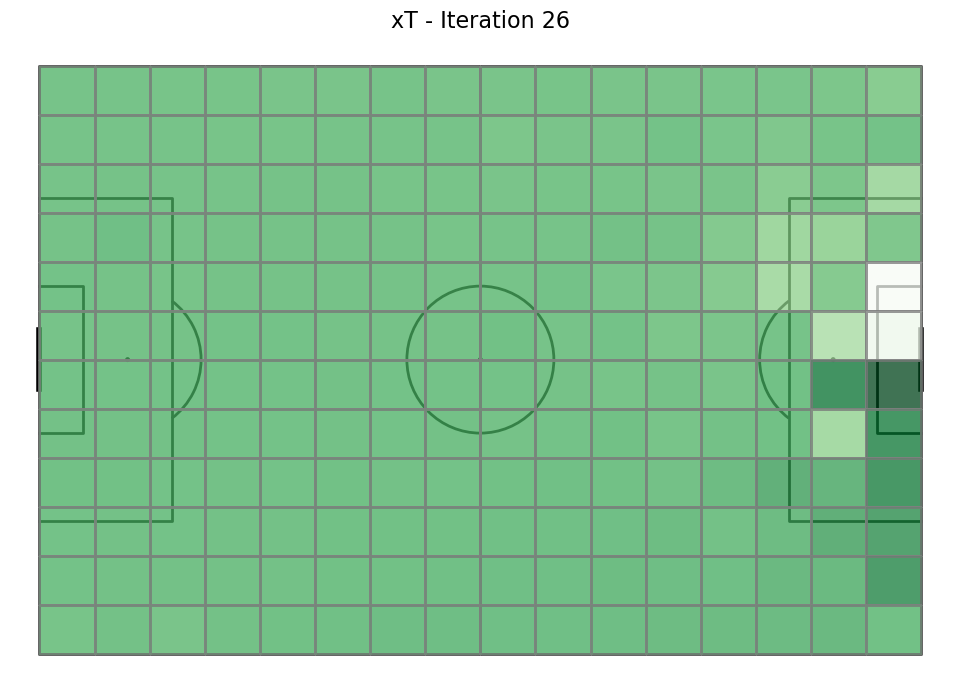

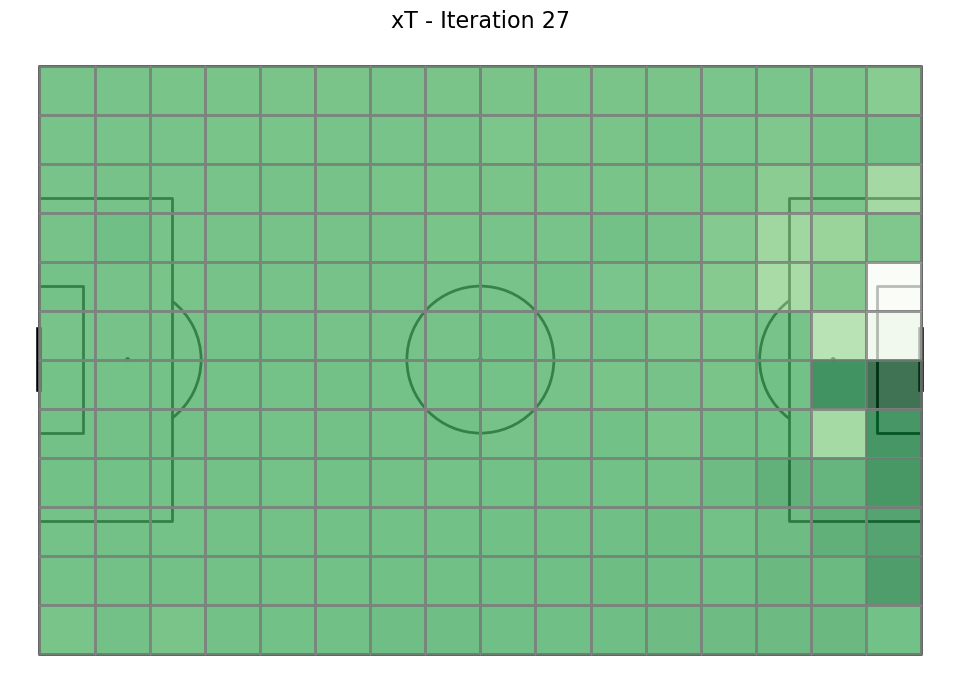

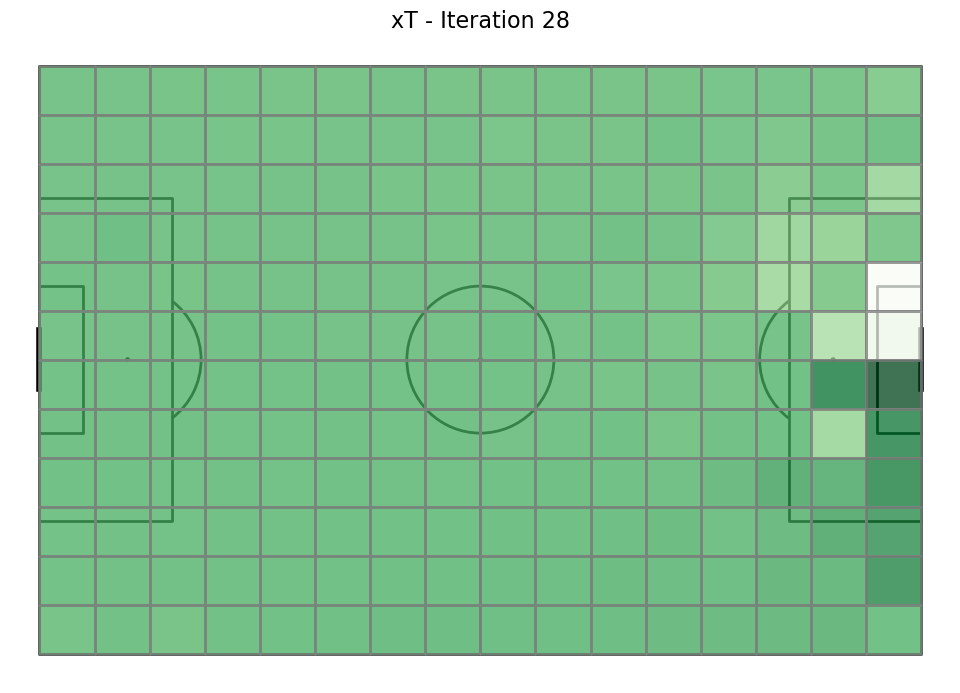

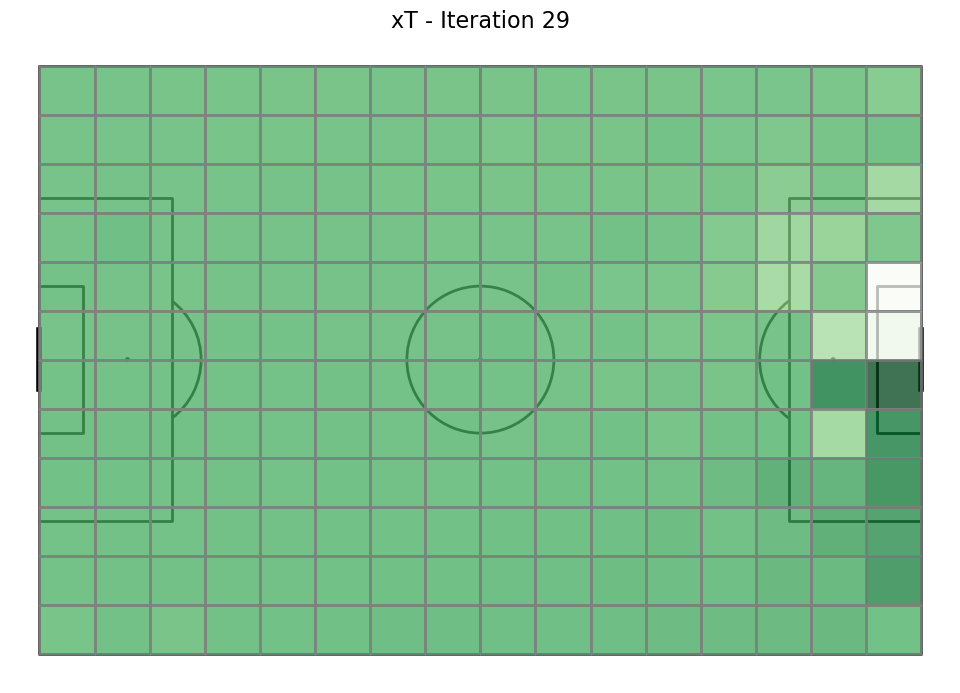

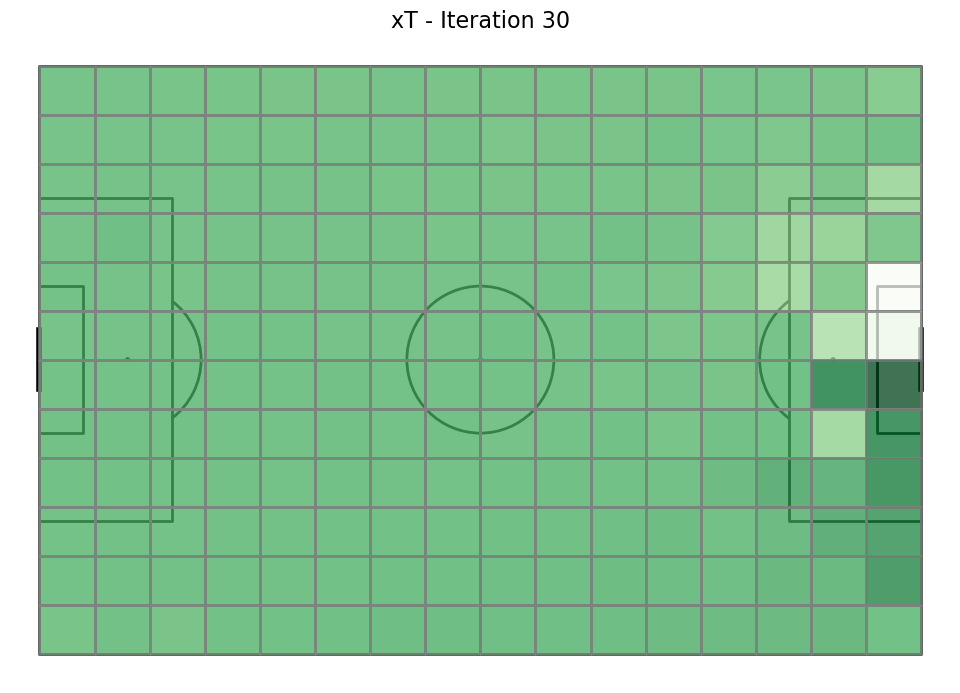

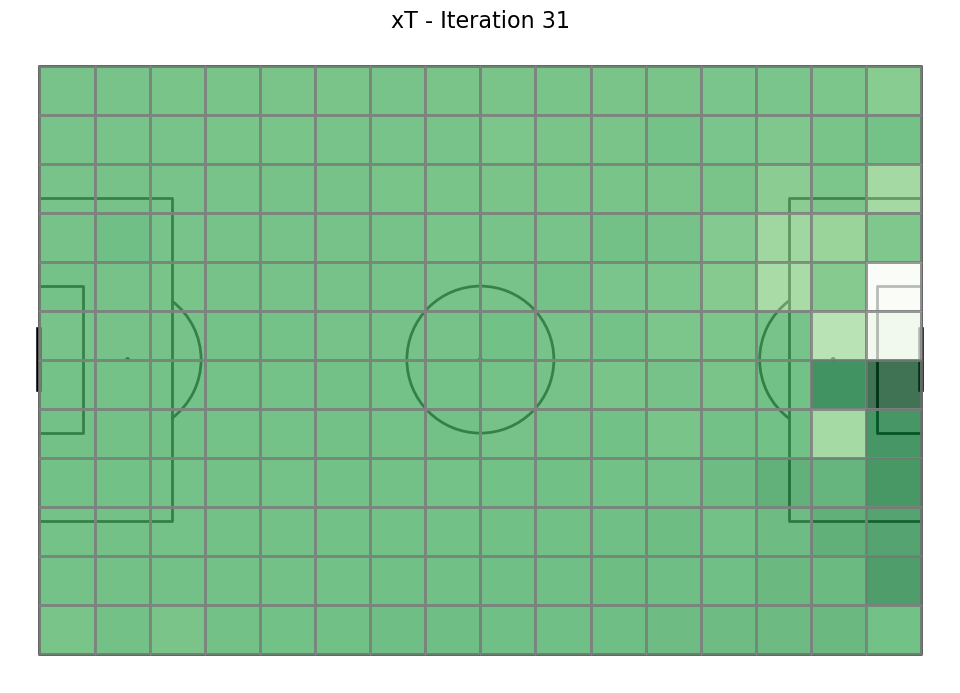

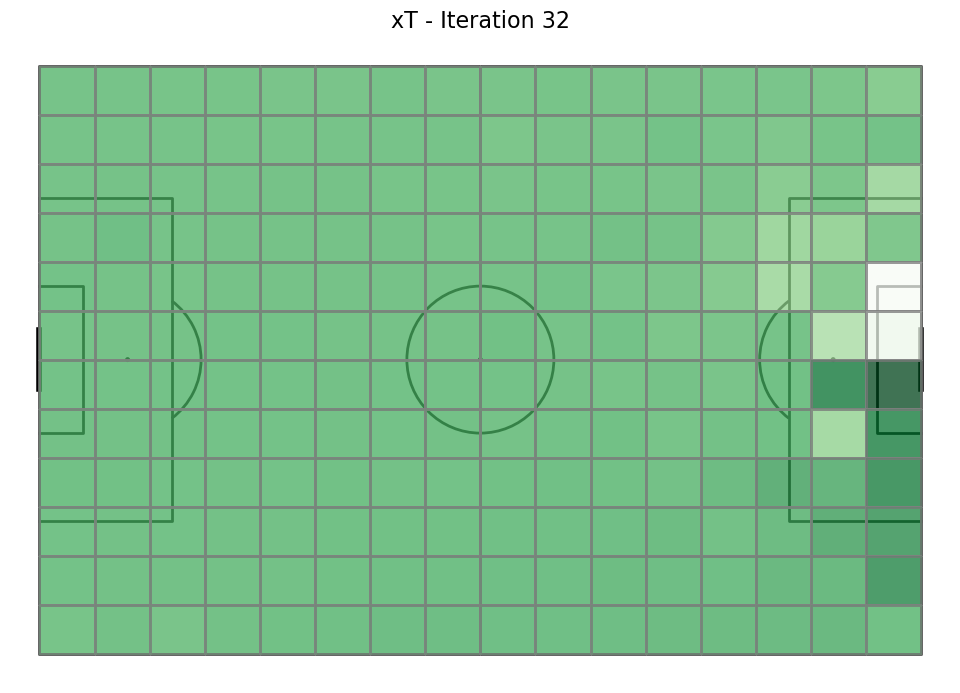

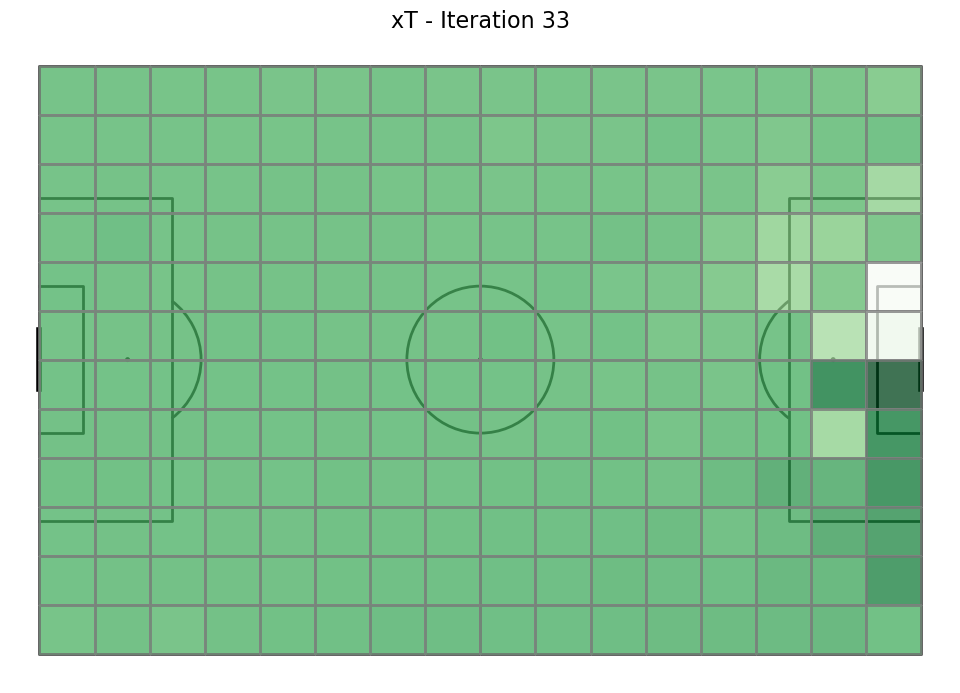

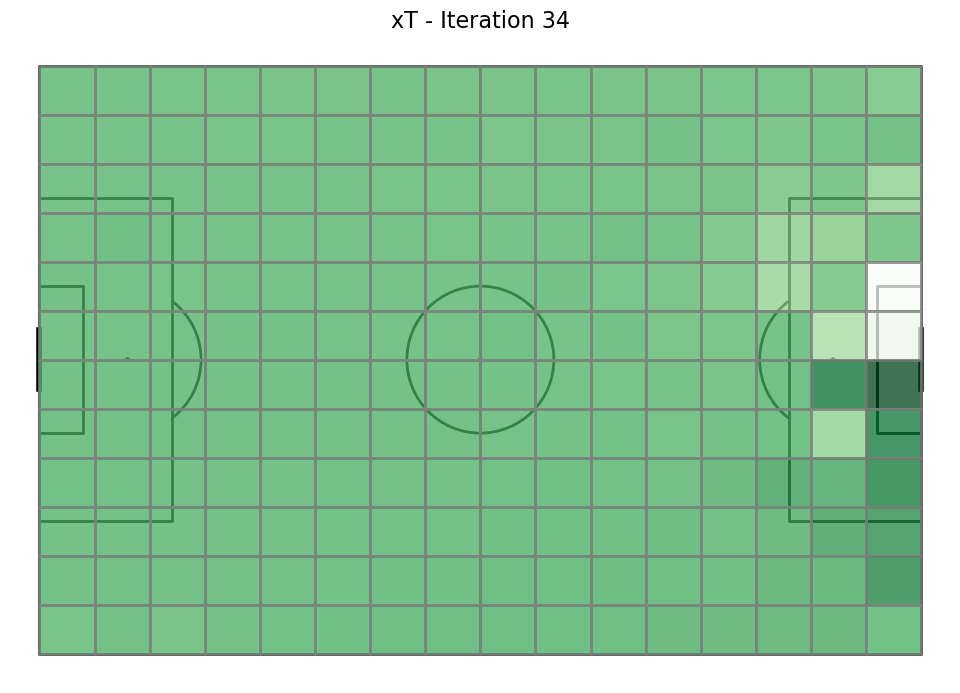

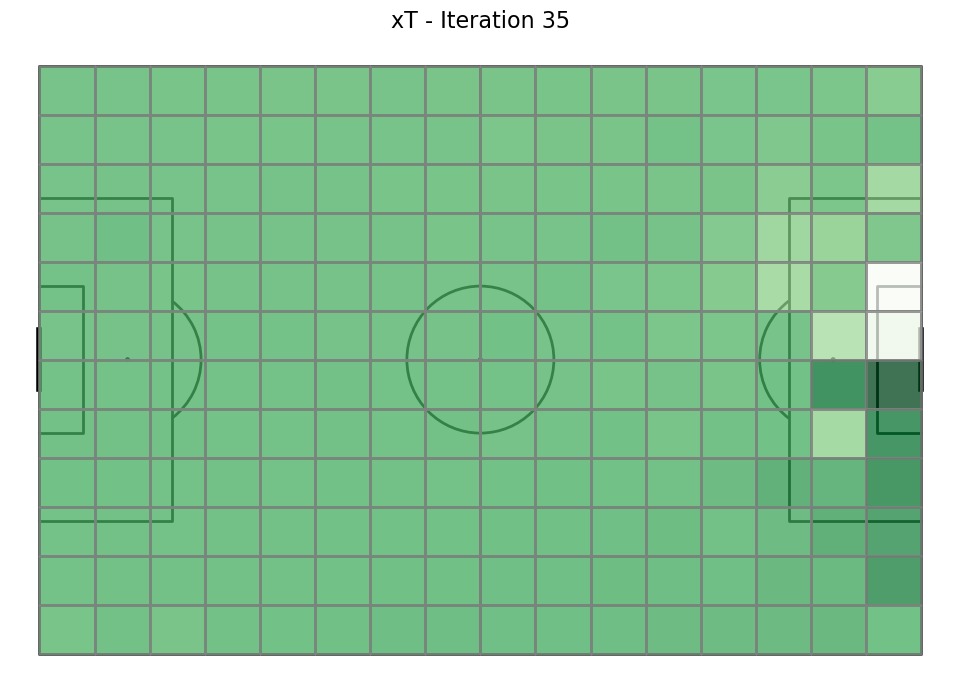

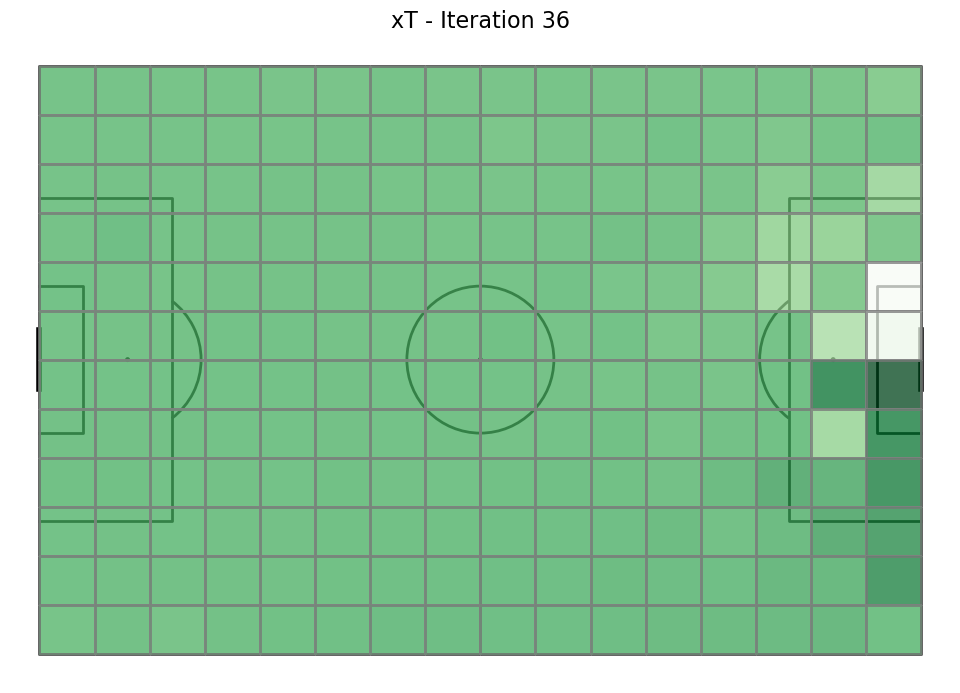

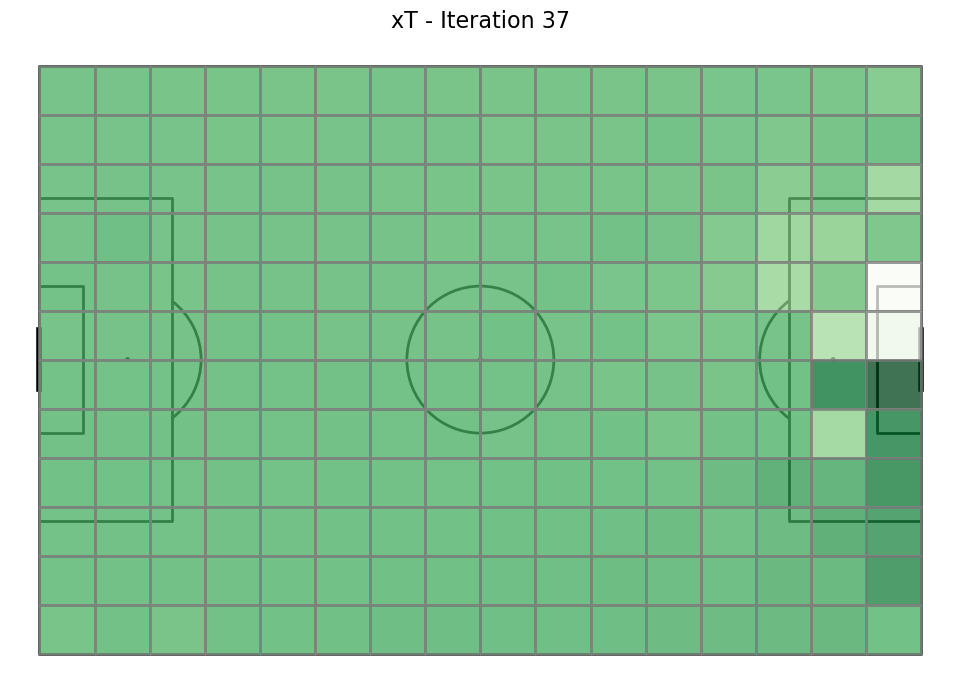

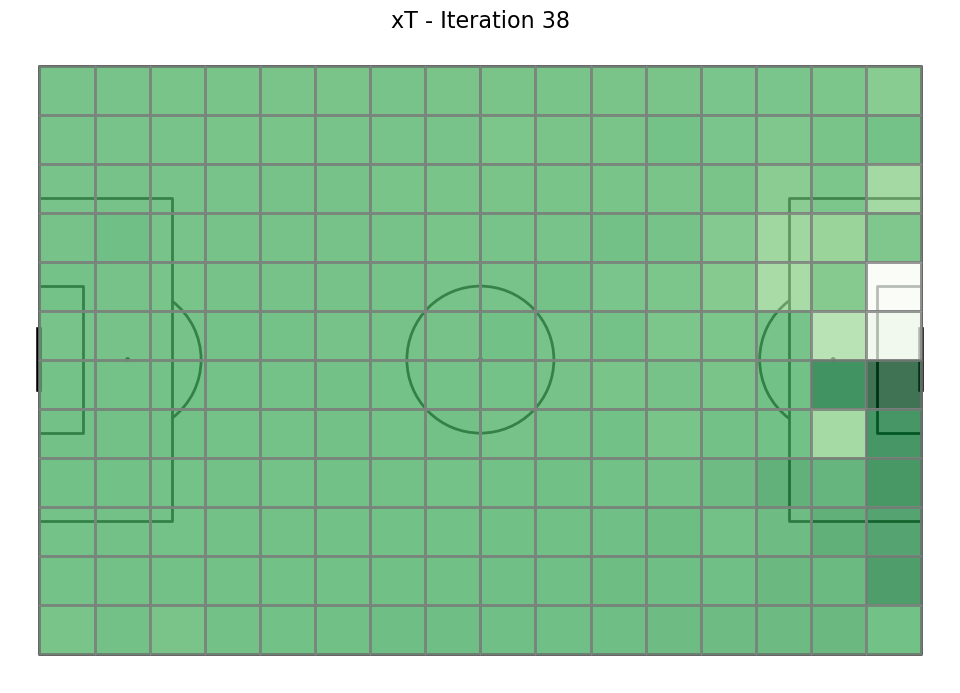

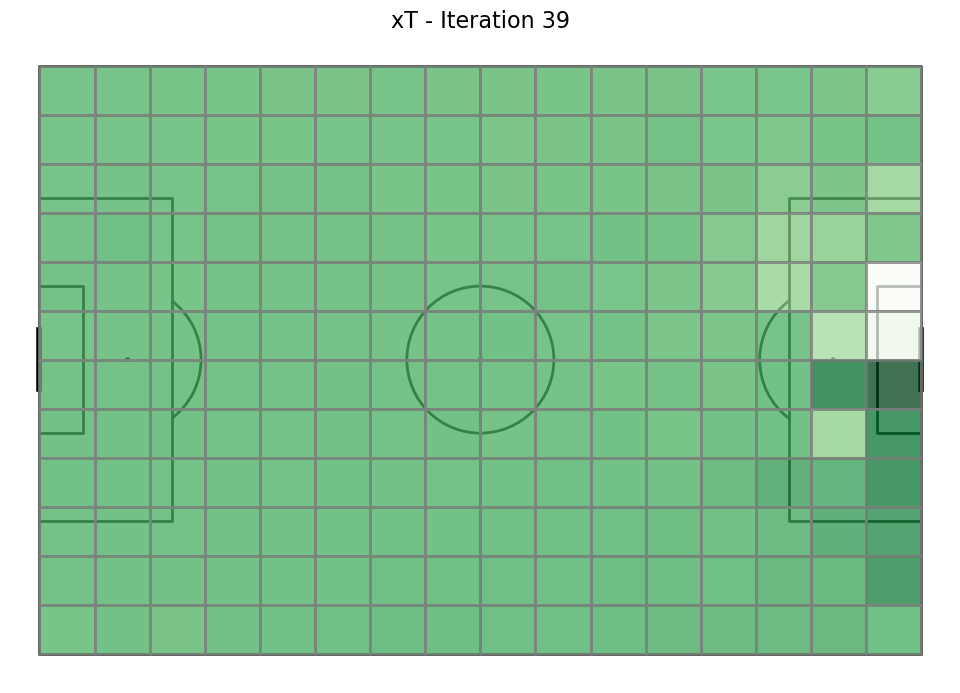

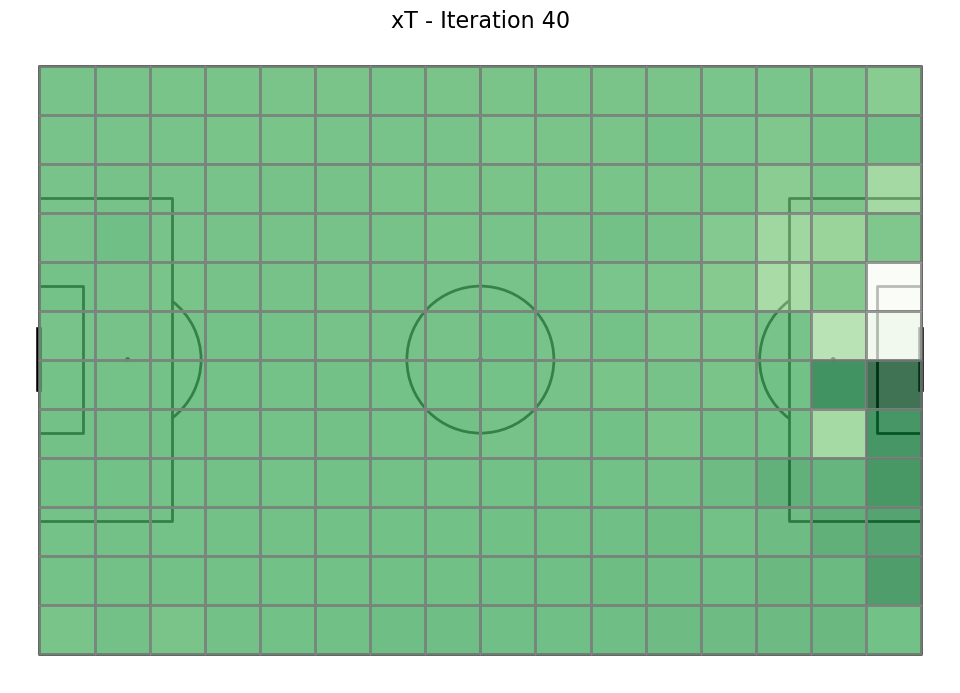

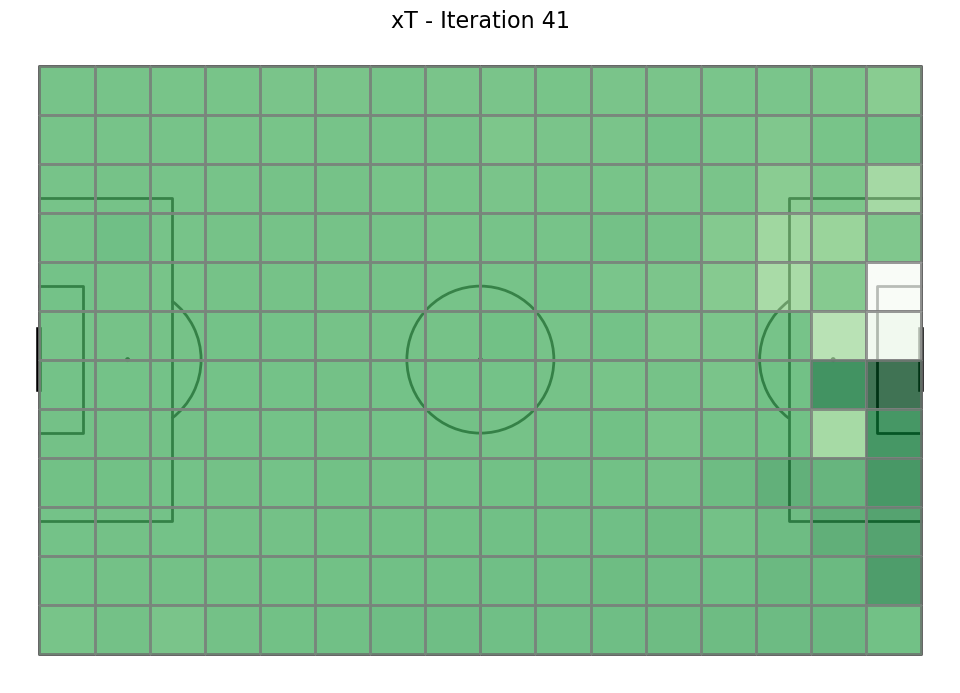

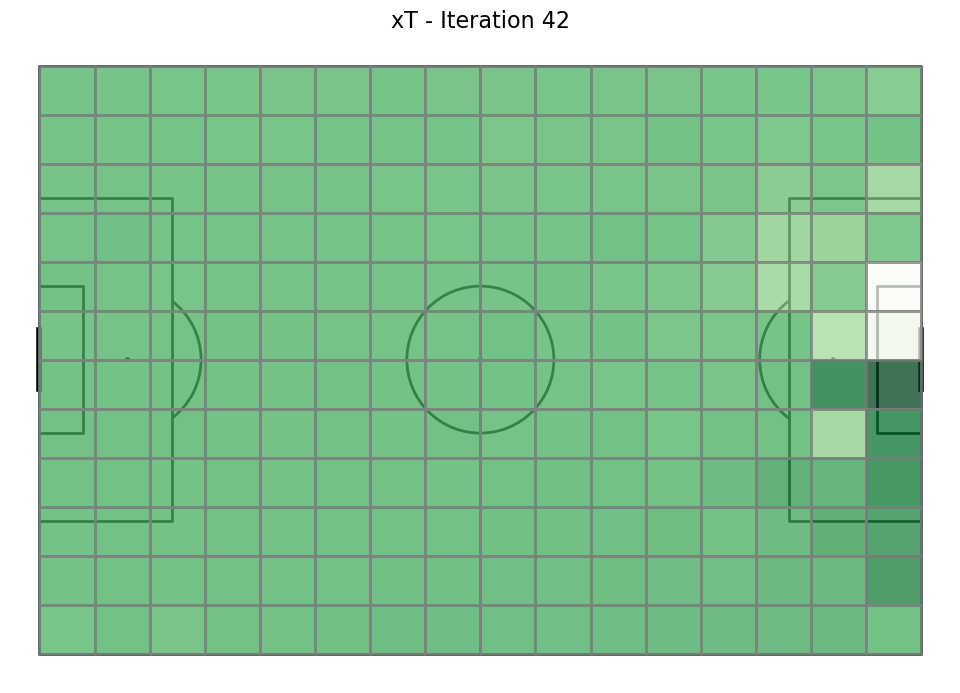

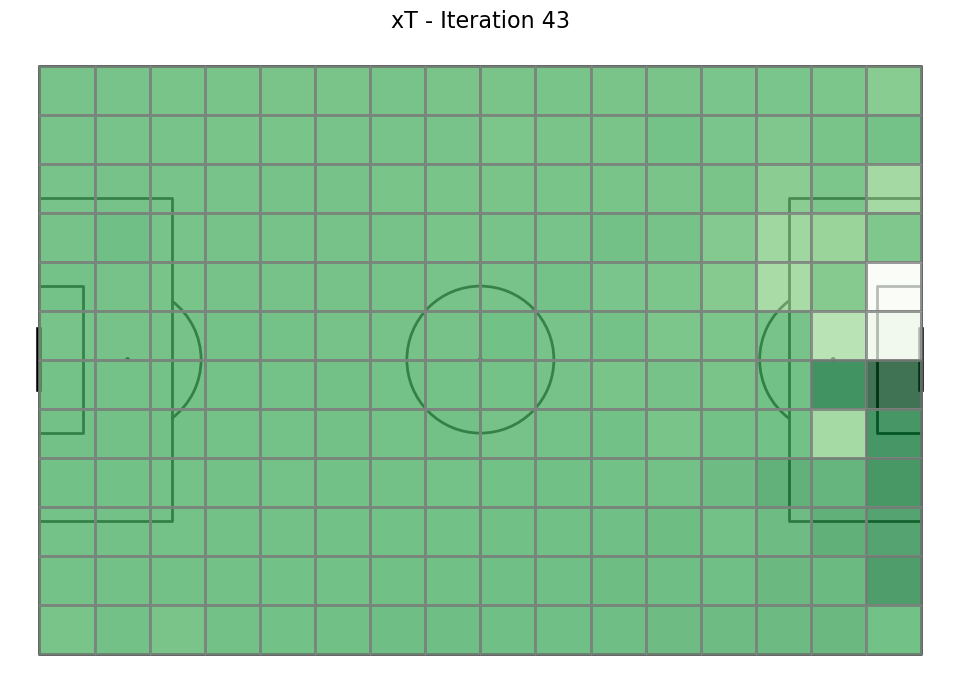

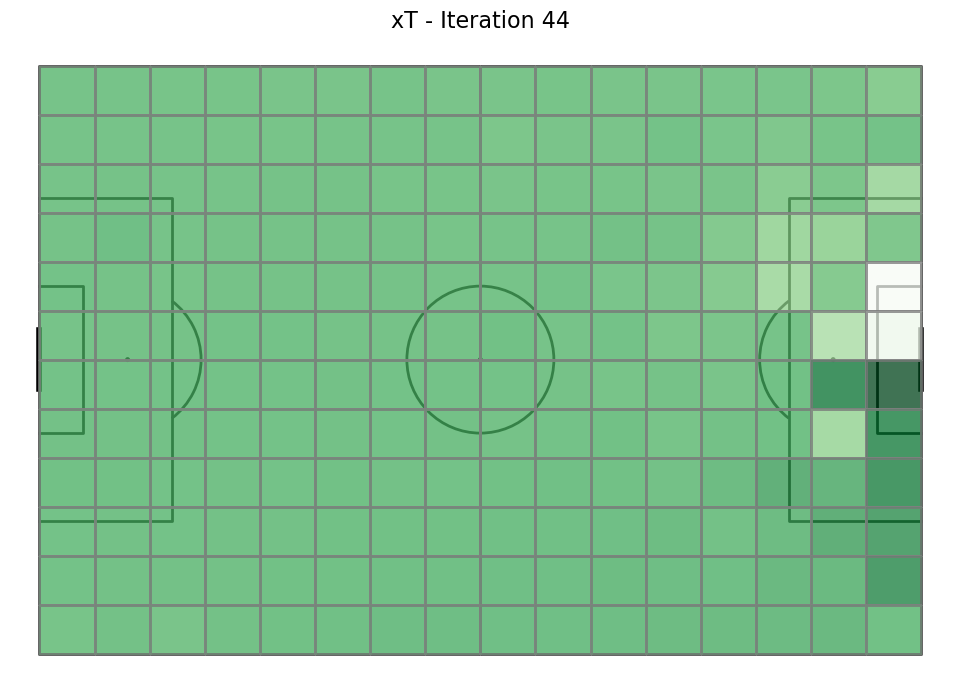

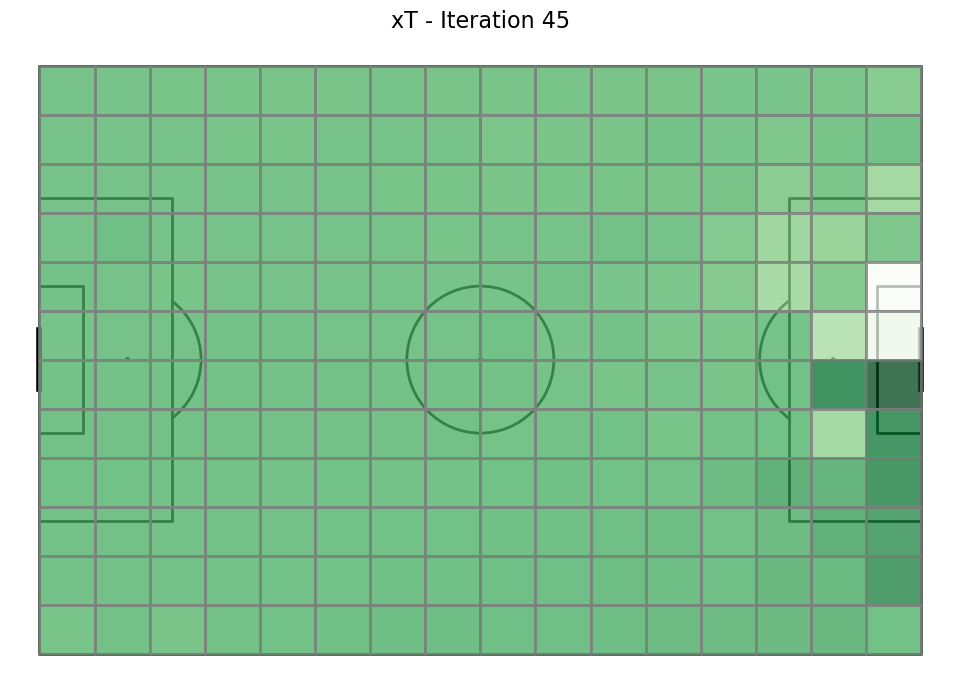

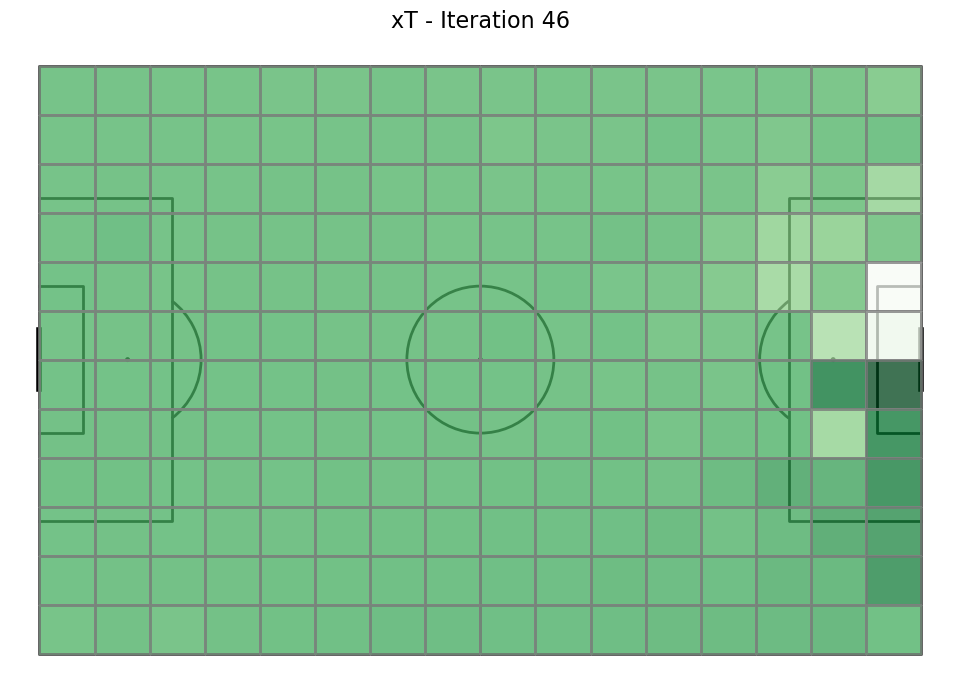

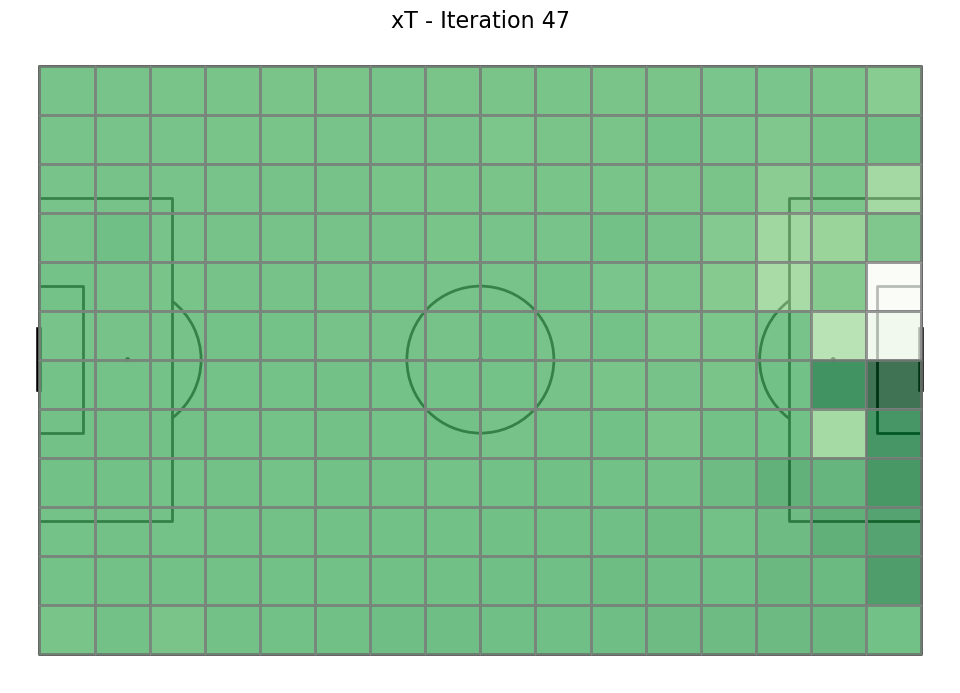

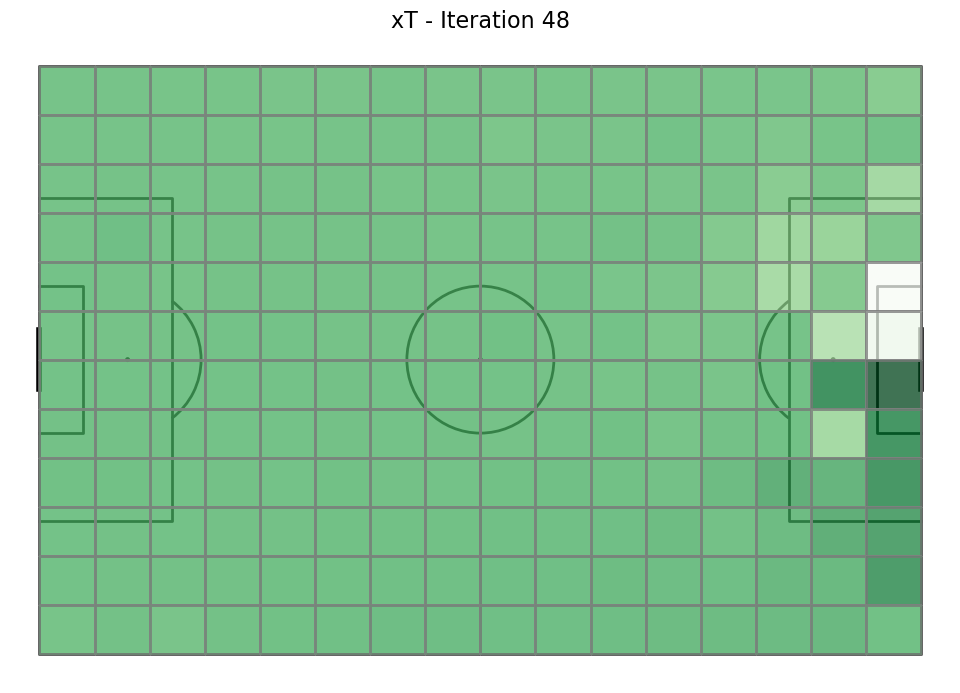

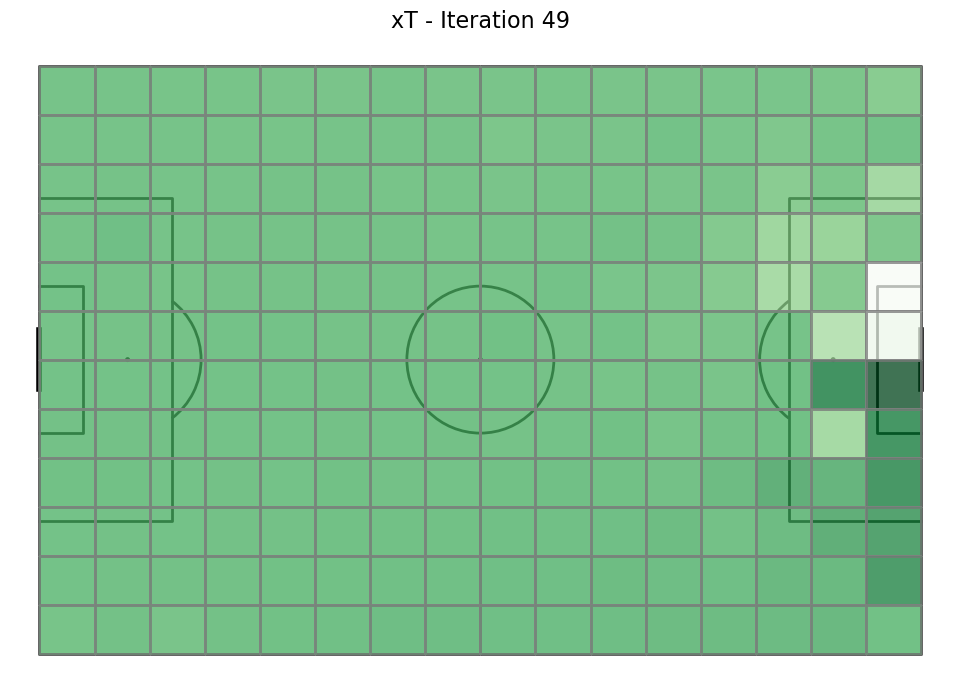

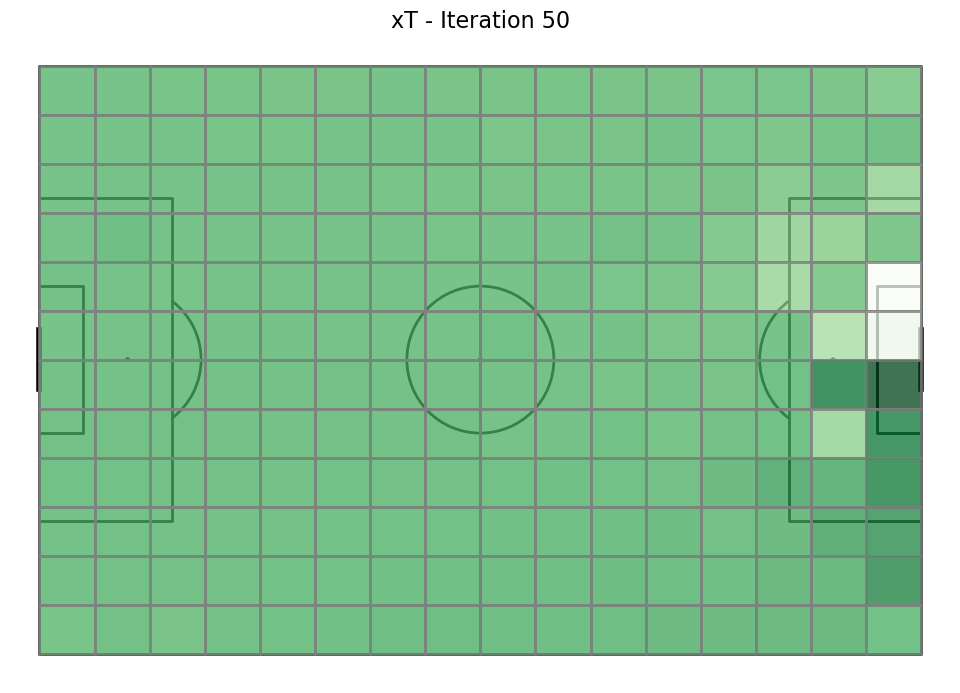

In [159]:
for iteration in range(50):
    new_xT = np.copy(xT)
    for i in range(GRID_X):
        for j in range(GRID_Y):
            future_threat = np.sum(P_trans[i, j] * xT)
            new_xT[i, j] = P_shot[i, j] * S[i, j] + P_move[i, j] * future_threat

    # Plot xT grid using mplsoccer
    pitch = mpl.Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
    fig, ax = pitch.draw(figsize=(10, 7))
    bin_statistic = pitch.bin_statistic(
        np.repeat(x_bins[:-1], GRID_Y) + (pitch_x / GRID_X / 2),
        np.tile(y_bins[:-1], GRID_X) + (pitch_y / GRID_Y / 2),
        values=new_xT.flatten(),
        statistic='mean',
        bins=(GRID_X, GRID_Y)
    )
    pitch.heatmap(bin_statistic, ax=ax, cmap='Greens', edgecolors='grey', alpha=0.75)
    ax.set_title(f"xT - Iteration {iteration + 1}", fontsize=16)
    plt.show()

    if np.sum(np.abs(new_xT - xT)) < 1e-6:
        print(f"Converged at iteration {iteration+1}")
        break
    xT = new_xT